# Create a classical statistic and machine learning for triathlon analysis database (find the difference)
## The pourpose of this analysis is:
- Find the differente from top 3 athlete and average 3 best perfomance in every discipline
  - There's a difference from top 3 and avg3?
  - The top 3 are the best athlete compared to the avg 3?
- Find the difference between top 3 and other position
  - Top 3 athletes is the best perfoprmer in every discipline?
  - There's a difference from top 3 and other position?
  - What is the pposition in the discipline for the top 3 athletes?
- Find the most influenced part of the race (excluded the transition)
  - Using different model of analysis, the result is the same?
  - using statistic and machine learning, qhat is the most influenced part of the race?
  - What is the second and third part of the race most influenced, and the difference betweet them



In [1]:
# install Thorch
!pip install torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from IPython.display import display, Math
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.stats import friedmanchisquare
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import itertools


To set the correct gender, uncomment the code below

In [3]:
# upload dataset (standard female o male) uncomment/comment

#train_data_path = "/content/drive/MyDrive/TRIATHLON ANALYSIS/db_standard_female_final.csv"
train_data_path = "/content/drive/MyDrive/TRIATHLON ANALYSIS/db_standard_male_final.csv"

In [4]:
train_df = pd.read_csv(train_data_path, low_memory=False) # open file
train_df.dtypes

,0
date_of_event,float64
event_date,object
position,int64
swim_time,float64
T1_time,float64
bike_time,float64
T2_time,float64
run_time,float64
total_time,float64
swim_position,float64


In [5]:
train_df.tail()

,date_of_event,event_date,position,swim_time,T1_time,bike_time,T2_time,run_time,total_time,swim_position,t1_position,bike_position,t2_position,run_position
45894,2024.0,25/05/2024,45,1132.0,34.0,3169.0,22.0,2088.0,6444.0,27.0,16.0,31.0,26.0,48.0
45895,2024.0,25/05/2024,46,1142.0,34.0,3333.0,23.0,1930.0,6460.0,37.0,18.0,49.0,36.0,37.0
45896,2024.0,25/05/2024,47,1157.0,37.0,3257.0,25.0,2020.0,6495.0,42.0,47.0,44.0,46.0,44.0
45897,2024.0,25/05/2024,48,1158.0,35.0,3258.0,25.0,2032.0,6505.0,44.0,30.0,45.0,47.0,47.0
45898,2024.0,25/05/2024,49,1161.0,36.0,3255.0,24.0,2183.0,6657.0,46.0,45.0,43.0,43.0,49.0


In [6]:
train_df.head()

,date_of_event,event_date,position,swim_time,T1_time,bike_time,T2_time,run_time,total_time,swim_position,t1_position,bike_position,t2_position,run_position
0,1986.0,22/06/1986,5,0.0,0.0,0.0,0.0,0.0,7420.0,2.0,2.0,2.0,2.0,2.0
1,1986.0,22/06/1986,16,0.0,0.0,0.0,0.0,0.0,7670.0,6.0,6.0,6.0,6.0,6.0
2,1986.0,22/06/1986,1,0.0,0.0,0.0,0.0,0.0,7190.0,13.0,13.0,13.0,13.0,13.0
3,1986.0,22/06/1986,2,0.0,0.0,0.0,0.0,0.0,7210.0,14.0,14.0,14.0,14.0,14.0
4,1987.0,31/05/1987,1,0.0,0.0,0.0,0.0,0.0,7092.0,1.0,1.0,1.0,1.0,1.0


Visualize dataset in a scatter chart to undestand the final position and the time

<ipython-input-7-645611716a2a>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_df['event_date'] = pd.to_datetime(train_df['event_date'])


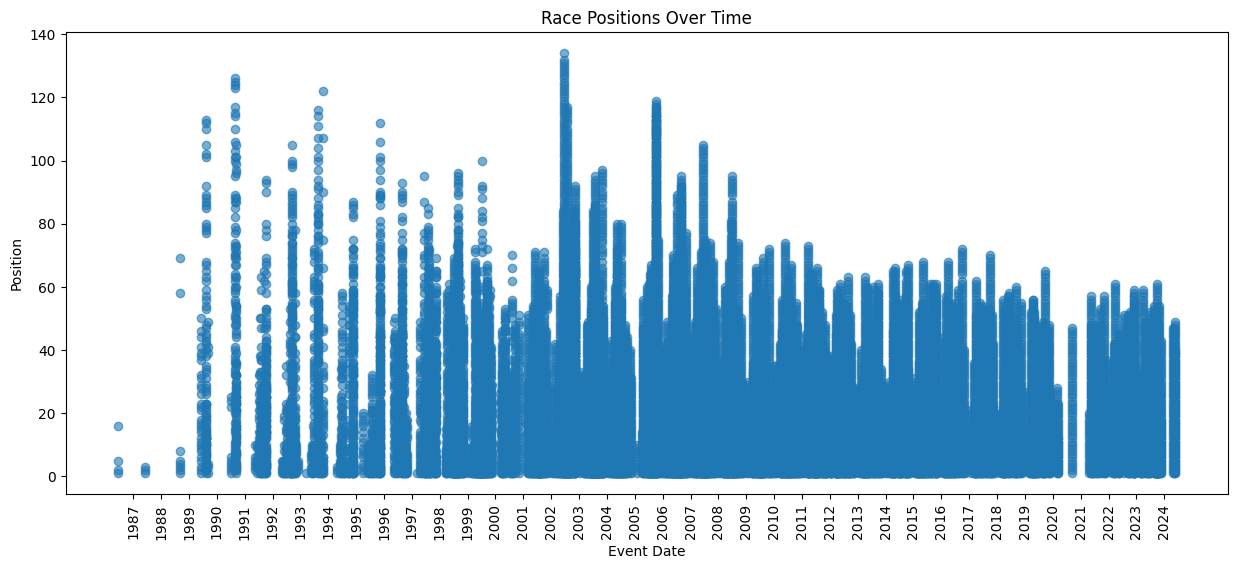

In [7]:
# Convert 'event_date' in datetime
train_df['event_date'] = pd.to_datetime(train_df['event_date'])

# sort DataFrame previously for 'event_date' and then for 'position'
df_sorted = train_df.sort_values(by=['event_date', 'position'])

# make a scatter plot
plt.figure(figsize=(15, 6))

years = pd.date_range(start=df_sorted['event_date'].min(),
                      end=df_sorted['event_date'].max(),
                      freq='YS')

plt.xticks(years.to_pydatetime(), years.year, rotation=90)

plt.scatter(df_sorted['event_date'], df_sorted['position'], alpha=0.6)
plt.title('Race Positions Over Time')
plt.xlabel('Event Date')
plt.ylabel('Position')

plt.show()

During the data cleaning in the previous notebook, some race are cutted for the position. a time below 2500 seconds are deleted from the dataset
In this chart we visualize the race with no firs, second or third position
- delete race before 1989/01/01
- delete all the race without the first, second and third position

In [8]:
# Specify the cutoff date
cutoff_date = '1989-01-01'

# Filter the DataFrame to remove rows before the cutoff date
df_sorted = df_sorted.loc[df_sorted['event_date'] >= cutoff_date]
df_sorted.reset_index(drop=True, inplace=True)
df_sorted

,date_of_event,event_date,position,swim_time,T1_time,bike_time,T2_time,run_time,total_time,swim_position,t1_position,bike_position,t2_position,run_position
0,1989.0,1989-06-11,1,1251.0,0.0,3887.0,0.0,2189.0,7328.0,6.0,1.0,2.0,1.0,25.0
1,1989.0,1989-06-11,2,1249.0,0.0,3982.0,0.0,2138.0,7374.0,5.0,2.0,5.0,2.0,19.0
2,1989.0,1989-06-11,3,1313.0,0.0,3978.0,0.0,2092.0,7384.0,15.0,3.0,4.0,3.0,7.0
3,1989.0,1989-06-11,5,1240.0,0.0,4009.0,0.0,2227.0,7478.0,2.0,5.0,8.0,5.0,32.0
4,1989.0,1989-06-11,6,1254.0,0.0,4156.0,0.0,2071.0,7481.0,8.0,6.0,22.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45879,2024.0,2024-05-25,45,1132.0,34.0,3169.0,22.0,2088.0,6444.0,27.0,16.0,31.0,26.0,48.0
45880,2024.0,2024-05-25,46,1142.0,34.0,3333.0,23.0,1930.0,6460.0,37.0,18.0,49.0,36.0,37.0
45881,2024.0,2024-05-25,47,1157.0,37.0,3257.0,25.0,2020.0,6495.0,42.0,47.0,44.0,46.0,44.0
45882,2024.0,2024-05-25,48,1158.0,35.0,3258.0,25.0,2032.0,6505.0,44.0,30.0,45.0,47.0,47.0


In [9]:
# Some information
length = len(df_sorted)
unique_race = len(df_sorted["event_date"].unique())
race_date = df_sorted["event_date"].unique().strftime('%Y-%m-%d')

print(f"Total row = {length}")
print(f"Total race is = {unique_race}")
print(f"Race date from {race_date[0]} to {race_date[-1]}")

Total row = 45884
Total race is = 1052
Race date from 1989-06-11 to 2024-05-25


In [10]:
# Group by year and event_date, then count the occurrences
df_sorted['date_of_event'] = df_sorted['date_of_event'].astype(int)
date_counts = df_sorted.groupby(['date_of_event', 'event_date']).size().reset_index(name='count')

# Filter to only keep dates that are repeated (i.e., count > 1)
repeated_dates = date_counts[date_counts['count'] > 1]

# Count the number of repeated dates for each year
repeated_dates_per_year = repeated_dates.groupby('date_of_event').size()

# Display the result
print(repeated_dates_per_year)

date_of_event
1989     3
1990     3
1991    12
1992    23
1993    12
1994    14
1995    13
1996    12
1997    24
1998    33
1999    43
2000    14
2001    33
2002    41
2003    55
2004    37
2005    38
2006    55
2007    47
2008    49
2009    43
2010    49
2011    49
2012    41
2013    41
2014    40
2015    42
2016    31
2017    31
2018    28
2019    28
2020     4
2021    14
2022    16
2023    27
2024     4
dtype: int64


In [1]:
# plot data
file_female= "/content/drive/MyDrive/TRIATHLON ANALYSIS/db_standard_female_final.csv"
if train_data_path == file_female:
  sex = "(Female)"
else:
  sex = "(Male)"


plt.figure(figsize=(10, 6))

repeated_dates_per_year.plot(kind='line', marker='.', color="#626262", alpha=0.7)
plt.title(f"Number of Event per Year {sex}")
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.xticks(ticks=repeated_dates_per_year.index, labels=repeated_dates_per_year.index, rotation=90)
plt.grid(True)

for x, y in zip(repeated_dates_per_year.index, repeated_dates_per_year):
    plt.text(int(x), y, str(y), ha="left", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()


NameError: name 'train_data_path' is not defined

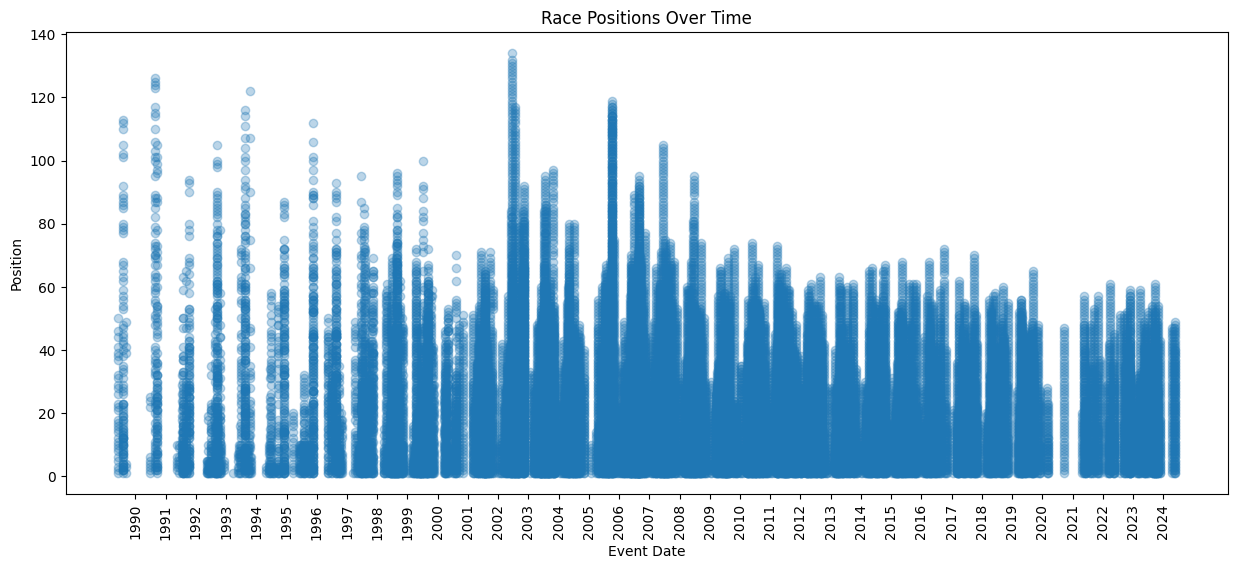

In [12]:
# make a scatter plot to conferm the cutting date
plt.figure(figsize=(15, 6))

years = pd.date_range(start=df_sorted['event_date'].min(),
                      end=df_sorted['event_date'].max(),
                      freq='YS')

plt.xticks(years.to_pydatetime(), years.year, rotation=90)

plt.scatter(df_sorted['event_date'], df_sorted['position'], alpha=0.3)
plt.title('Race Positions Over Time')
plt.xlabel('Event Date')
plt.ylabel('Position')

plt.show()

In [13]:
# Supponendo che 'df_sorted' sia il DataFrame iniziale con i dati ordinati
def filter_races_with_positions(df, position_col='position', event_col='event_date'):
    # Lista degli eventi da mantenere (quelli che hanno le posizioni 1, 2 e 3)
    valid_events = []

    # Raggruppa per 'event_date'
    for date, group in df.groupby(event_col):
        # Verifica se tutte le posizioni 1, 2, e 3 sono presenti
        if all(pos in group[position_col].values for pos in [1, 2, 3]):
            valid_events.append(date)

    # Filtra il DataFrame mantenendo solo gli eventi con tutte le posizioni 1, 2 e 3
    filtered_df = df[df[event_col].isin(valid_events)]

    return filtered_df

# Applica la funzione al DataFrame
df_filtered = filter_races_with_positions(df_sorted)

# Verifica il risultato
print(f"Numero di eventi originali: {df_sorted['event_date'].nunique()}")
print(f"Numero di eventi dopo il filtro: {df_filtered['event_date'].nunique()}")

# Se necessario, procedi con le operazioni di calcolo su 'df_filtered'


Numero di eventi originali: 1052
Numero di eventi dopo il filtro: 989


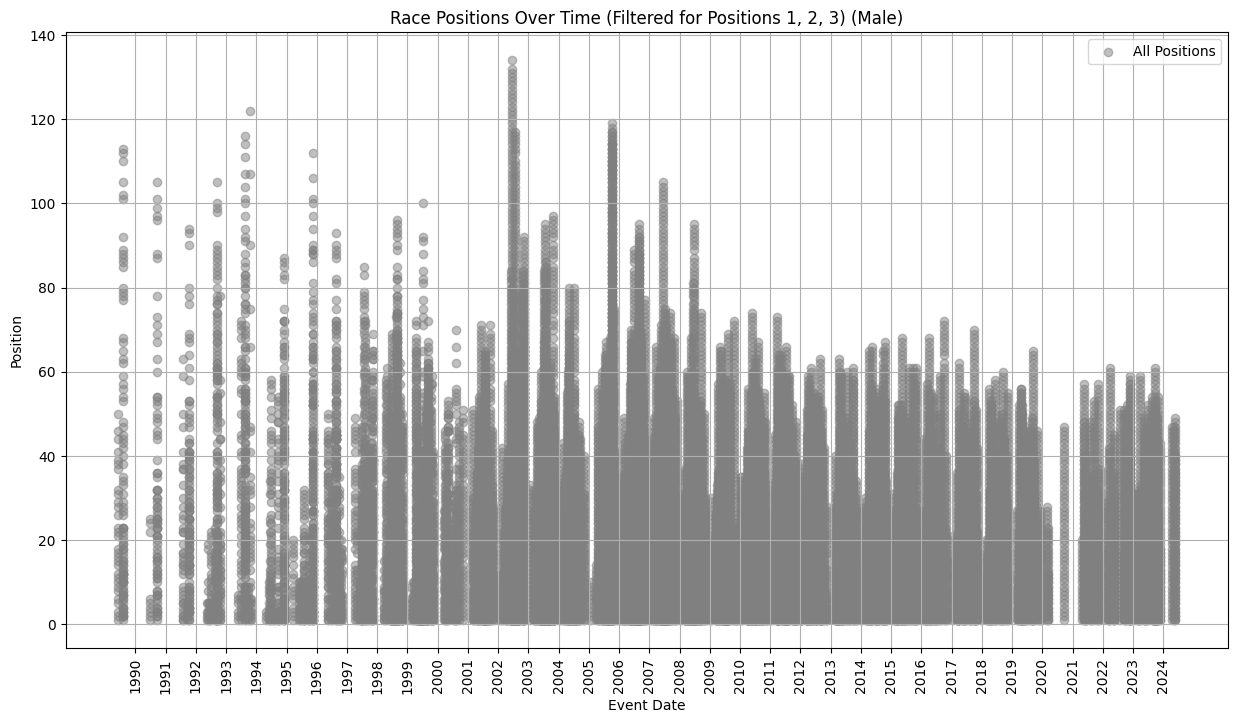

In [14]:
# Supponiamo che df_filtered sia il DataFrame filtrato in base alla presenza delle posizioni 1, 2 e 3
plt.figure(figsize=(15, 8))

# Grafico di tutte le posizioni nel DataFrame filtrato
plt.scatter(df_filtered['event_date'], df_filtered['position'], color='gray', label='All Positions', alpha=0.5)

# Impostazioni per l'asse x
years = pd.date_range(start=df_filtered['event_date'].min(),
                      end=df_filtered['event_date'].max(),
                      freq='YS')

plt.xticks(years.to_pydatetime(), years.year, rotation=90)

# Impostazioni del grafico
plt.title(f'Race Positions Over Time (Filtered for Positions 1, 2, 3) {sex}')
plt.xlabel('Event Date')
plt.ylabel('Position')
# plt.gca().invert_yaxis()  # Se vuoi invertire l'asse y
# plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)
plt.show()


To have correct data also in the test dataset, visualize the position and the date for the test dataset

We need to check if the data have not duplicates or null row for train and test dataset

In [15]:
# Check for duplicates for train dataset
duplicates = train_df.duplicated()
if duplicates.any():
    print("Found duplicates. Removing...")
    # Remove duplicates
    df_final_train = train_df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

# Check for missing data in any row
missing_data = train_df.isnull().any(axis=1)
if missing_data.any():
    print(f"Found rows with missing data. Removing {missing_data.sum()} rows...")
    # Remove rows with missing data
    train_df = train_df.dropna()
    print("Rows with missing data removed.")
else:
    print("No missing data found.")

Found duplicates. Removing...
Duplicates removed.
No missing data found.


# Make a standard statistic analysis
The analysis have different pourpose:

1. Find average time of the top 3 athlete
2. Discorver the correlation between race
3. Find the performance of the top 3 athlete
4. There's a correltion if I use teh top 3 final position or user the top 3 position in swmi, bike and run?
5. Using a simple linear regression, can I determine the total time of the race in Paris 2024?



Create 2 dataframe
1. With top 3 athlete (the 1st, 2nd, and 3rd place of the race)
2. with the best 3 time in swim, bike, run and total time

In [16]:
# Funzione per creare il dataframe 'top3'
def create_top3_structure(df, event_col, swim_col, bike_col, run_col, total_time_col, position_col):
    # Filtra per le prime 3 posizioni per ogni evento
    top3_df = df[df[position_col] <= 3].sort_values(by=[event_col, position_col]).groupby(event_col).head(3)

    # Seleziona solo le colonne necessarie
    top3_df = top3_df[[event_col, swim_col, bike_col, run_col, total_time_col]]

    return top3_df

# Funzione per creare il dataframe 'avg3' con la stessa struttura
def create_avg3_structure(df, event_col, swim_col, bike_col, run_col, total_time_col):
    avg3_df = pd.DataFrame(columns=[event_col, swim_col, bike_col, run_col, total_time_col])

    for event in df[event_col].unique():
        event_data = df[df[event_col] == event]

        # Prendi i 3 migliori tempi per ciascuna disciplina
        swim_times = event_data[swim_col].nsmallest(3).values
        bike_times = event_data[bike_col].nsmallest(3).values
        run_times = event_data[run_col].nsmallest(3).values
        total_times = event_data[total_time_col].nsmallest(3).values

        # Solo se ci sono esattamente 3 valori validi per ciascuna disciplina
        if len(swim_times) == 3 and len(bike_times) == 3 and len(run_times) == 3 and len(total_times) == 3:
            event_df = pd.DataFrame({
                event_col: [event] * 3,
                swim_col: swim_times,
                bike_col: bike_times,
                run_col: run_times,
                total_time_col: total_times
            })

            avg3_df = pd.concat([avg3_df, event_df], ignore_index=True)

    return avg3_df

# Applica la funzione ai dati filtrati
train_df_top3 = create_top3_structure(df_filtered, 'event_date', 'swim_time', 'bike_time', 'run_time', 'total_time', 'position')
train_df_avg3 = create_avg3_structure(df_filtered, 'event_date', 'swim_time', 'bike_time', 'run_time', 'total_time')

# Verifica se i due dataset hanno la stessa lunghezza e le stesse colonne
print(f"Lunghezza top3: {len(train_df_top3)}")
print(f"Lunghezza avg3: {len(train_df_avg3)}")
print(f"Colonne top3: {train_df_top3.columns.tolist()}")
print(f"Colonne avg3: {train_df_avg3.columns.tolist()}")

# Mostra le prime righe di ciascun dataset per verifica
print(train_df_top3.head())
print(train_df_avg3.head())


<ipython-input-16-2f27ab4b39ae>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avg3_df = pd.concat([avg3_df, event_df], ignore_index=True)


Lunghezza top3: 2967
Lunghezza avg3: 2967
Colonne top3: ['event_date', 'swim_time', 'bike_time', 'run_time', 'total_time']
Colonne avg3: ['event_date', 'swim_time', 'bike_time', 'run_time', 'total_time']
   event_date  swim_time  bike_time  run_time  total_time
0  1989-06-11     1251.0     3887.0    2189.0      7328.0
1  1989-06-11     1249.0     3982.0    2138.0      7374.0
2  1989-06-11     1313.0     3978.0    2092.0      7384.0
30 1989-08-06     1702.0     3436.0    1987.0      7125.0
31 1989-08-06     1605.0     3586.0    2012.0      7203.0
  event_date  swim_time  bike_time  run_time  total_time
0 1989-06-11        0.0        0.0    2040.0      7328.0
1 1989-06-11     1240.0     3887.0    2045.0      7374.0
2 1989-06-11     1243.0     3978.0    2071.0      7384.0
3 1989-08-06        0.0        0.0       0.0      7125.0
4 1989-08-06        0.0        0.0       0.0      7203.0


In [17]:
# Controlla il numero di righe in ciascun dataset
len_top3 = len(train_df_top3)
len_avg3 = len(train_df_avg3)

# Confronta le lunghezze
if len_top3 == len_avg3:
    print(f"I due dataset hanno la stessa lunghezza: {len_top3} righe.")
else:
    print(f"I dataset hanno lunghezze diverse. top3: {len_top3} righe, avg3: {len_avg3} righe.")


I due dataset hanno la stessa lunghezza: 2967 righe.


In [18]:
# big_chart function to use any dataframe passed as an argument

def big_chart(df, df_name):

    # Convert date to datetime if not already done
    df.loc[:, 'event_date'] = pd.to_datetime(df['event_date'])

    years = pd.date_range(start=df['event_date'].min(),
                          end=df['event_date'].max(),
                          freq='YS')

    # Calculate mean and standard deviation
    mean_swim = df['swim_time'].mean()
    std_swim = df['swim_time'].std() * 2

    mean_bike = df['bike_time'].mean()
    std_bike = df['bike_time'].std() * 2

    mean_run = df['run_time'].mean()
    std_run = df['run_time'].std() * 2

    mean_total = df['total_time'].mean()
    std_total = df['total_time'].std() * 2

    # Make a chart for the data
    plt.figure(figsize=(20, 12))

    plt.subplot(4, 1, 1)
    plt.scatter(df['event_date'], df['swim_time'], label='Swim Time', color='blue', alpha=0.3)
    plt.axhline(mean_swim, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_swim + std_swim, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_swim - std_swim, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Swim Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    #plt.ylim(0, 2000)
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.scatter(df['event_date'], df['bike_time'], label='Bike Time', color='green', alpha=0.3)
    plt.axhline(mean_bike, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_bike + std_bike, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_bike - std_bike, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Bike Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    #plt.ylim(0, 6000)
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.scatter(df['event_date'], df['run_time'], label='Run Time', color='red', alpha=0.3)
    plt.axhline(mean_run, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_run + std_run, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_run - std_run, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Run Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    #plt.ylim(0, 3600)
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.scatter(df['event_date'], df['total_time'], label='Total Time', color='purple', alpha=0.3)
    plt.axhline(mean_total, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_total + std_total, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_total - std_total, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Total Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    #plt.ylim(3600, 10000)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Use the big_chart function with different dataframes


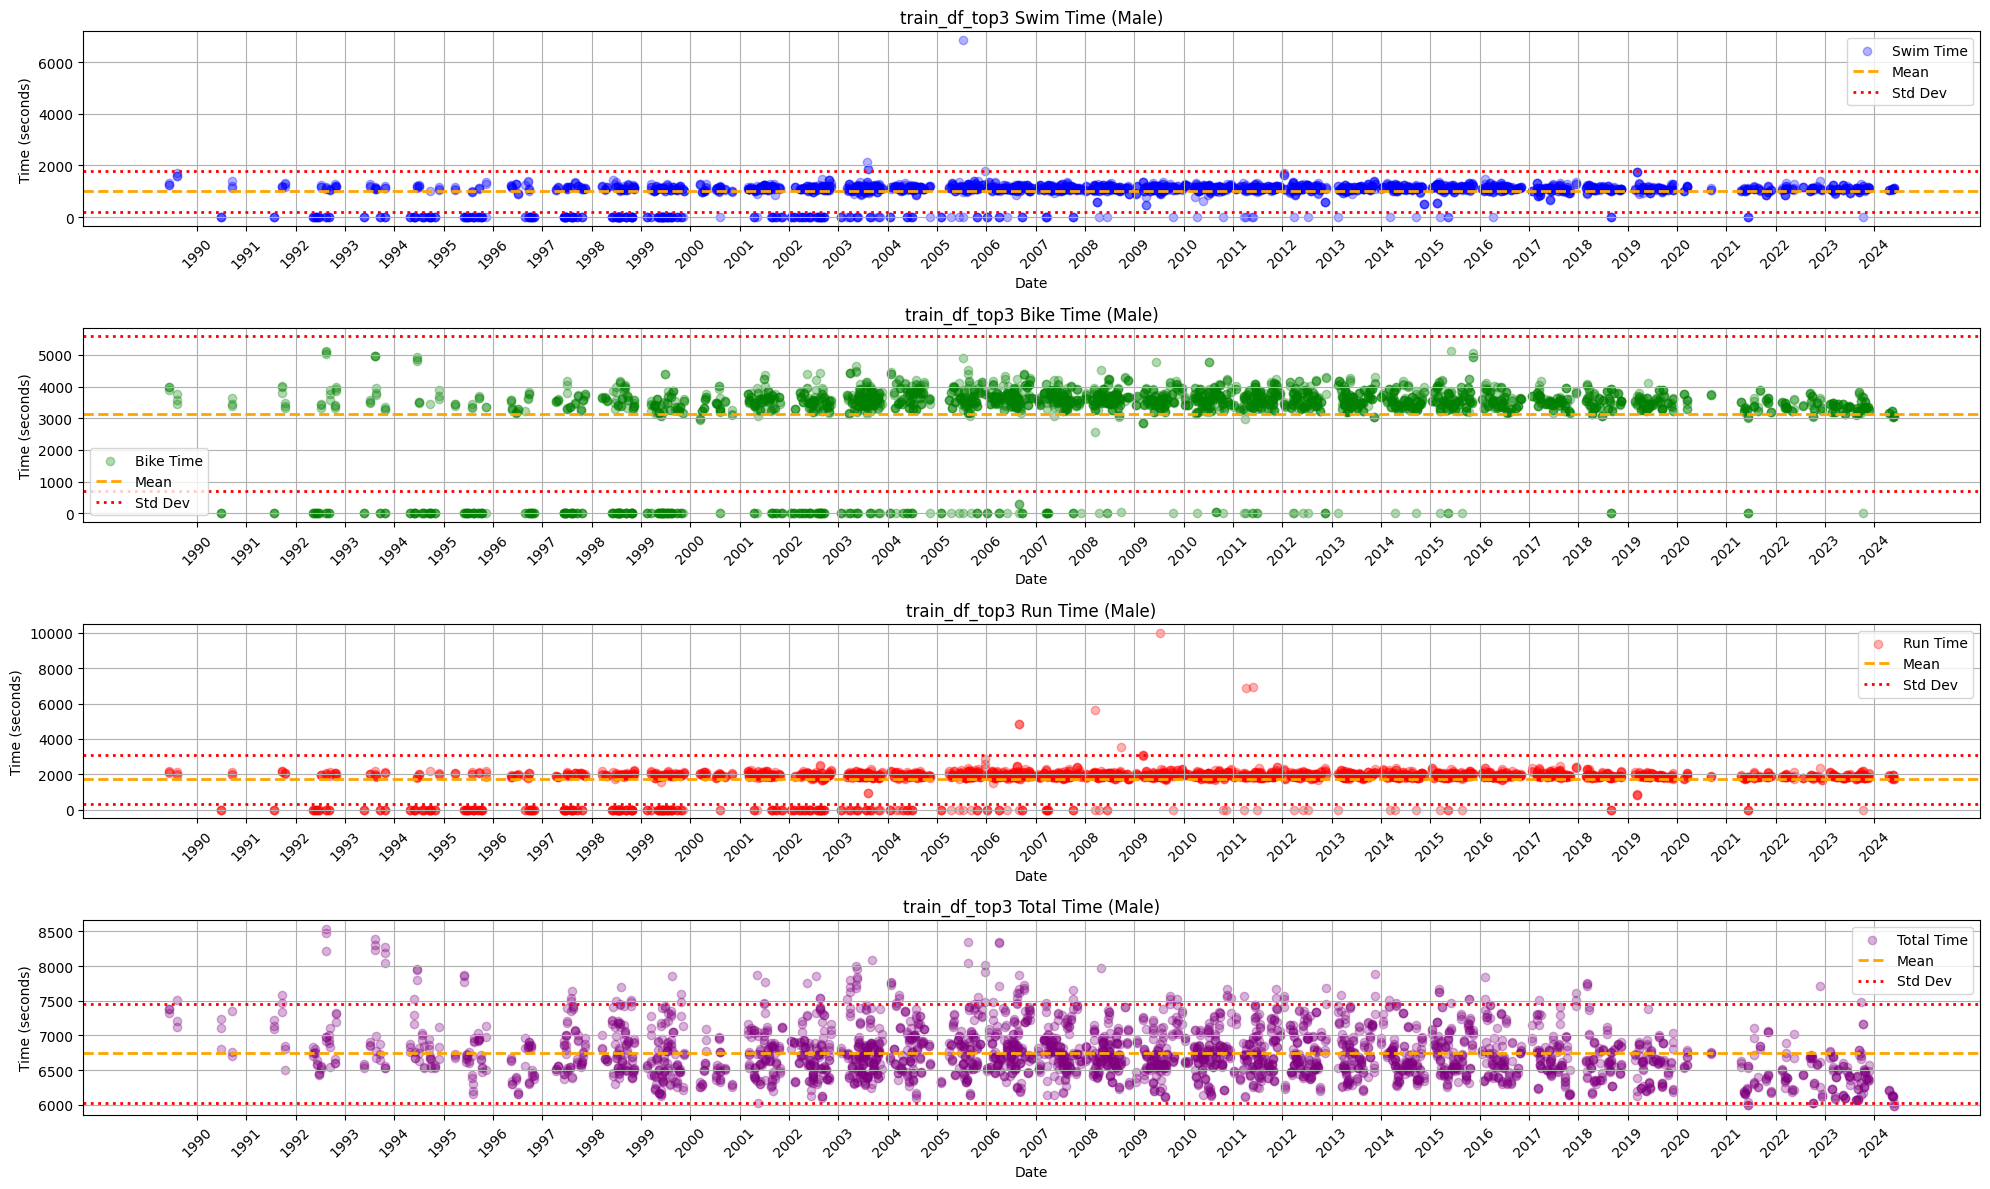

In [19]:
big_chart(train_df_top3, "train_df_top3")

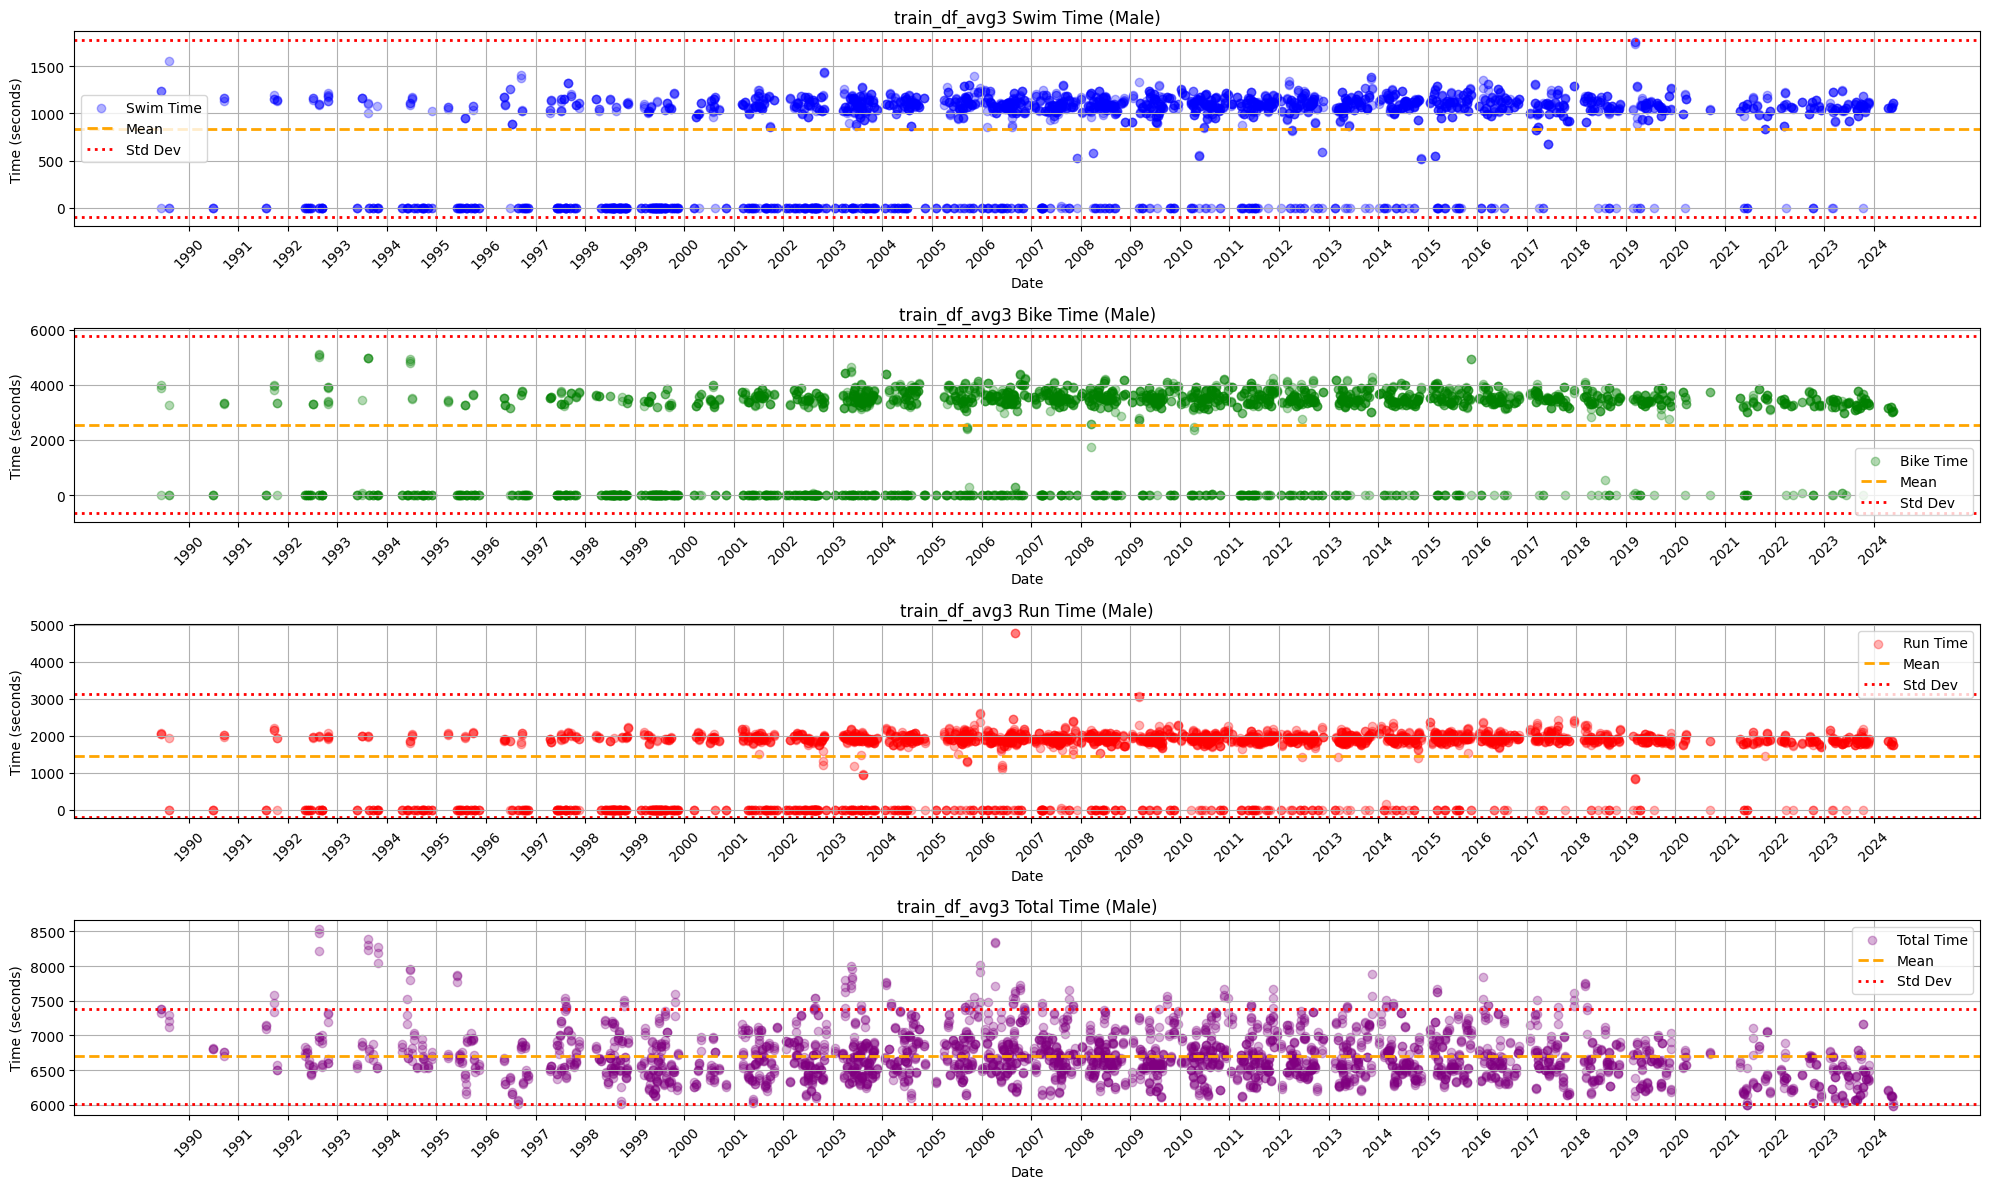

In [20]:
big_chart(train_df_avg3, "train_df_avg3")

In [21]:
# calculate the correlation

def calcola_correlazione(df1, df2):
    corr = df1[['swim_time', 'bike_time', 'run_time', 'total_time']].corrwith(df2[['swim_time', 'bike_time', 'run_time', 'total_time']])
    return corr


In [22]:
# calculate the t test

def calcola_ttest_latex(df1, df2):
    ttest_results = {}
    for col in ['swim_time', 'bike_time', 'run_time', 'total_time']:
        t_stat, p_value = ttest_ind(df1[col], df2[col], equal_var=False)
        ttest_results[col] = {'t_statistic': t_stat, 'p_value': p_value}

        # Creare la rappresentazione LaTeX
        formula_latex = f"For {col}: \, T = {t_stat:.4f}, \, P = {p_value:.12f}"
        display(Math(formula_latex))

        if p_value < 0.01:
            print("Interpretation: Very Good - There is a highly significant difference between the disciplines.")
        elif 0.01 <= p_value < 0.05:
            print("Interpretation: Good - There is a significant difference between the disciplines.")
        elif 0.05 <= p_value < 0.10:
            print("Interpretation: Moderate - There is a marginal difference between the disciplines.")
        elif 0.10 <= p_value < 0.20:
            print("Interpretation: Poor - There is little to no significant difference between the disciplines.")
        else:
            print("Interpretation: Very Poor - There is no significant difference between the disciplines.")

    return ttest_results


In [23]:
def allinea_dataframes(df1, df2, on_column='event_date'):
    merged_df = pd.merge(df1, df2, on=on_column, suffixes=('_avg3', '_top3'))
    return merged_df


In [24]:
#calculate the rsquared

def calcola_rquadro_latex(df1, df2):
    merged_df = allinea_dataframes(df1, df2)
    r2_results = {}
    for col in ['swim_time', 'bike_time', 'run_time', 'total_time']:
        r2 = r2_score(merged_df[f'{col}_avg3'], merged_df[f'{col}_top3'])
        r2_results[col] = r2

        # Creare la rappresentazione LaTeX
        formula_latex = f"R^2 \\text{{ for }} {col} = {r2:.4f}"
        display(Math(formula_latex))

    return r2_results


In [25]:
# create heatmap of the correlation

def plot_heatmap_correlazione(df1, df2):
    combined_df = pd.concat([df1[['swim_time', 'bike_time', 'run_time', 'total_time']],
                             df2[['swim_time', 'bike_time', 'run_time', 'total_time']]],
                            axis=1)
    combined_df.columns = ['swim_time_avg3', 'bike_time_avg3', 'run_time_avg3', 'total_time_avg3',
                           'swim_time_top3', 'bike_time_top3', 'run_time_top3', 'total_time_top3']
    corr = combined_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(f"Heat Map correlation between two dataset {sex}")
    plt.show()


In [26]:
# make linear regression

def regressione_lineare(df1, df2):
    merged_df = allinea_dataframes(df1, df2)
    results = {}
    for col in ['swim_time', 'bike_time', 'run_time', 'total_time']:
        model = LinearRegression()
        X = merged_df[[f'{col}_avg3']].values.reshape(-1, 1)
        y = merged_df[f'{col}_top3'].values
        model.fit(X, y)
        r2 = model.score(X, y)
        coef = model.coef_[0]
        intercept = model.intercept_
        results[col] = {
            'formula': f"${col}_top3 = {coef:.4f} \cdot {col}_avg3 + {intercept:.4f}$",
            'r2': r2
        }
    return results


In [27]:
# make polinomial regression

def regressione_polinomiale(df1, df2, degree):
    merged_df = allinea_dataframes(df1, df2)
    results = {}
    for col in ['swim_time', 'bike_time', 'run_time', 'total_time']:
        polynomial_features = PolynomialFeatures(degree=degree)
        model = make_pipeline(polynomial_features, LinearRegression())
        X = merged_df[[f'{col}_avg3']].values.reshape(-1, 1)
        y = merged_df[f'{col}_top3'].values
        model.fit(X, y)
        r2 = model.score(X, y)

        # Ottieni i coefficienti (incl. l'intercept) dal modello
        coeffs = model.named_steps['linearregression'].coef_
        intercept = model.named_steps['linearregression'].intercept_

        # Creazione della formula in LaTeX
        terms = [f"{coeff:.4f}x^{i}" for i, coeff in enumerate(coeffs)]
        formula = f"${col}_top3 = {intercept:.4f} + " + " + ".join(terms) + "$"

        results[col] = {
            'formula': formula,
            'r2': r2
        }
    return results


In [28]:
# create heat map

def plot_heatmap_ttest(ttest_results):
    # Creare DataFrame per statistiche T e p-values
    t_stat_df = pd.DataFrame({col: [ttest_results[col]['t_statistic']] for col in ttest_results})
    p_value_df = pd.DataFrame({col: [ttest_results[col]['p_value']] for col in ttest_results})

    # Plot heatmap per T-statistiche
    plt.figure(figsize=(10, 2))
    sns.heatmap(t_stat_df, annot=True, cmap='coolwarm', cbar=True, fmt=".4f")
    plt.title(f'Heatmap for T-test {sex}')
    plt.show()

    # Plot heatmap per P-values
    plt.figure(figsize=(10, 2))
    sns.heatmap(p_value_df, annot=True, cmap='coolwarm', cbar=True, fmt=".8f")
    plt.title(f'Heatmap for P-values {sex}')
    plt.show()


In [29]:
from scipy.stats import ttest_ind

# Funzione per convertire le colonne in tipi numerici
def ensure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Supponiamo che le colonne di interesse siano queste
columns_to_check = ['swim_time', 'bike_time', 'run_time', 'total_time']

# Convertire le colonne in tipi numerici
train_df_avg3 = ensure_numeric(train_df_avg3, columns_to_check)
train_df_top3 = ensure_numeric(train_df_top3, columns_to_check)

<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


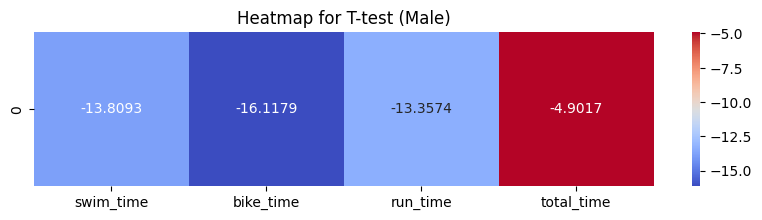

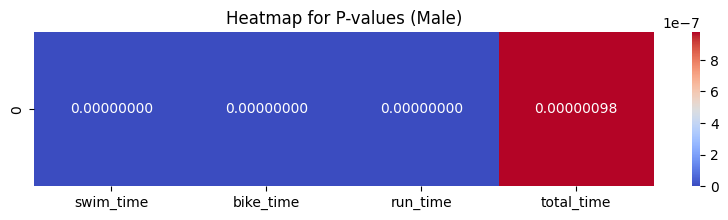

In [30]:
# Utilizzo della funzione
ttest_results = calcola_ttest_latex(train_df_avg3, train_df_top3)
plot_heatmap_ttest(ttest_results)

In [31]:
from scipy.stats import ttest_ind

# Carica i dataset
# Supponiamo che i dataset siano già caricati in df1 e df2
df1 = train_df_top3
df2 = train_df_avg3

# Esegui il t-test su total_time
t_stat, p_value = ttest_ind(df1['total_time'], df2['total_time'], equal_var=False)

# Interpreta i risultati
print(f"T-test: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Le medie di 'total_time' tra i due dataset sono significativamente diverse.")
else:
    print("Le medie di 'total_time' tra i due dataset non sono significativamente diverse.")


T-test: 4.901737702054674
P-value: 9.75238871629528e-07
Le medie di 'total_time' tra i due dataset sono significativamente diverse.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

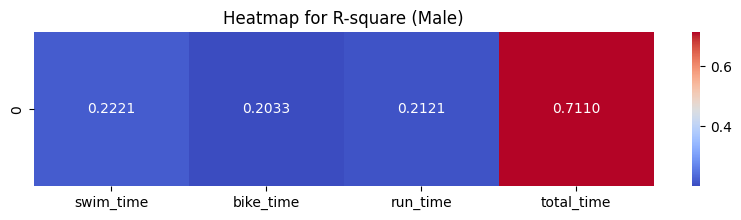

In [32]:
def plot_heatmap_rquadro(r2_results):
    # Creare un DataFrame per R-quadro
    r2_df = pd.DataFrame(r2_results, index=[0])

    # Plot heatmap per R-quadro
    plt.figure(figsize=(10, 2))
    sns.heatmap(r2_df, annot=True, cmap='coolwarm', cbar=True, fmt=".4f")
    plt.title(f'Heatmap for R-square {sex}')
    plt.show()

# Utilizzo della funzione
r2_results = calcola_rquadro_latex(train_df_avg3, train_df_top3)
plot_heatmap_rquadro(r2_results)


<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


<IPython.core.display.Math object>

Interpretation: Very Good - There is a highly significant difference between the disciplines.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

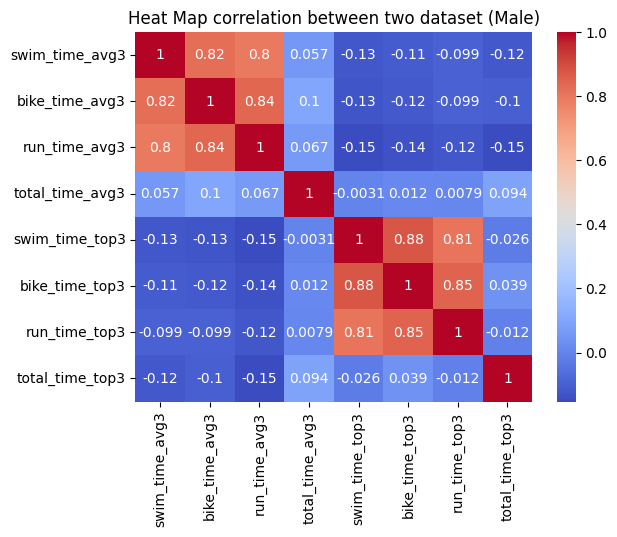

In [33]:
# make calculation

merged_df = allinea_dataframes(train_df_avg3, train_df_top3)
corr = calcola_correlazione(train_df_avg3[['swim_time', 'bike_time', 'run_time', 'total_time']],
                            train_df_top3[['swim_time', 'bike_time', 'run_time', 'total_time']],)
ttest_results = calcola_ttest_latex(train_df_avg3[['swim_time', 'bike_time', 'run_time', 'total_time']],
                              train_df_top3[['swim_time', 'bike_time', 'run_time', 'total_time']],)
r2 = calcola_rquadro_latex(train_df_avg3, train_df_top3)
plot_heatmap_correlazione(train_df_avg3, train_df_top3)


In [34]:
# Calcolare la regressione lineare e visualizzare i risultati
lin_reg_results = regressione_lineare(train_df_avg3, train_df_top3)

# Calcolare la regressione polinomiale di grado 3 e visualizzare i risultati
poly_reg_results = regressione_polinomiale(train_df_avg3, train_df_top3, degree=3)

lin_reg_results
poly_reg_results


{'swim_time': {'formula': '$swim_time_top3 = 575.5224 + 0.0000x^0 + 0.0068x^1 + 0.0006x^2 + -0.0000x^3$',
  'r2': 0.3820517183776223},
 'bike_time': {'formula': '$bike_time_top3 = 1995.7678 + 0.0000x^0 + 0.4142x^1 + -0.0001x^2 + 0.0000x^3$',
  'r2': 0.3722063475856795},
 'run_time': {'formula': '$run_time_top3 = 1000.9495 + 0.0000x^0 + 0.0615x^1 + 0.0003x^2 + -0.0000x^3$',
  'r2': 0.3666330944021958},
 'total_time': {'formula': '$total_time_top3 = 31377.8070 + 0.0000x^0 + -11.8917x^1 + 0.0018x^2 + -0.0000x^3$',
  'r2': 0.7596511959992733}}

# Position analysis
The pourpose of this analysis is that the winner of the race sometime had the best time in swim, bike or run.

We want to analyze the difference between finel position and swim, bike and run position

In [35]:
df_filtered

,date_of_event,event_date,position,swim_time,T1_time,bike_time,T2_time,run_time,total_time,swim_position,t1_position,bike_position,t2_position,run_position
0,1989,1989-06-11,1,1251.0,0.0,3887.0,0.0,2189.0,7328.0,6.0,1.0,2.0,1.0,25.0
1,1989,1989-06-11,2,1249.0,0.0,3982.0,0.0,2138.0,7374.0,5.0,2.0,5.0,2.0,19.0
2,1989,1989-06-11,3,1313.0,0.0,3978.0,0.0,2092.0,7384.0,15.0,3.0,4.0,3.0,7.0
3,1989,1989-06-11,5,1240.0,0.0,4009.0,0.0,2227.0,7478.0,2.0,5.0,8.0,5.0,32.0
4,1989,1989-06-11,6,1254.0,0.0,4156.0,0.0,2071.0,7481.0,8.0,6.0,22.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45879,2024,2024-05-25,45,1132.0,34.0,3169.0,22.0,2088.0,6444.0,27.0,16.0,31.0,26.0,48.0
45880,2024,2024-05-25,46,1142.0,34.0,3333.0,23.0,1930.0,6460.0,37.0,18.0,49.0,36.0,37.0
45881,2024,2024-05-25,47,1157.0,37.0,3257.0,25.0,2020.0,6495.0,42.0,47.0,44.0,46.0,44.0
45882,2024,2024-05-25,48,1158.0,35.0,3258.0,25.0,2032.0,6505.0,44.0,30.0,45.0,47.0,47.0


In [36]:
df_filtered.dropna()
df_filtered

,date_of_event,event_date,position,swim_time,T1_time,bike_time,T2_time,run_time,total_time,swim_position,t1_position,bike_position,t2_position,run_position
0,1989,1989-06-11,1,1251.0,0.0,3887.0,0.0,2189.0,7328.0,6.0,1.0,2.0,1.0,25.0
1,1989,1989-06-11,2,1249.0,0.0,3982.0,0.0,2138.0,7374.0,5.0,2.0,5.0,2.0,19.0
2,1989,1989-06-11,3,1313.0,0.0,3978.0,0.0,2092.0,7384.0,15.0,3.0,4.0,3.0,7.0
3,1989,1989-06-11,5,1240.0,0.0,4009.0,0.0,2227.0,7478.0,2.0,5.0,8.0,5.0,32.0
4,1989,1989-06-11,6,1254.0,0.0,4156.0,0.0,2071.0,7481.0,8.0,6.0,22.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45879,2024,2024-05-25,45,1132.0,34.0,3169.0,22.0,2088.0,6444.0,27.0,16.0,31.0,26.0,48.0
45880,2024,2024-05-25,46,1142.0,34.0,3333.0,23.0,1930.0,6460.0,37.0,18.0,49.0,36.0,37.0
45881,2024,2024-05-25,47,1157.0,37.0,3257.0,25.0,2020.0,6495.0,42.0,47.0,44.0,46.0,44.0
45882,2024,2024-05-25,48,1158.0,35.0,3258.0,25.0,2032.0,6505.0,44.0,30.0,45.0,47.0,47.0


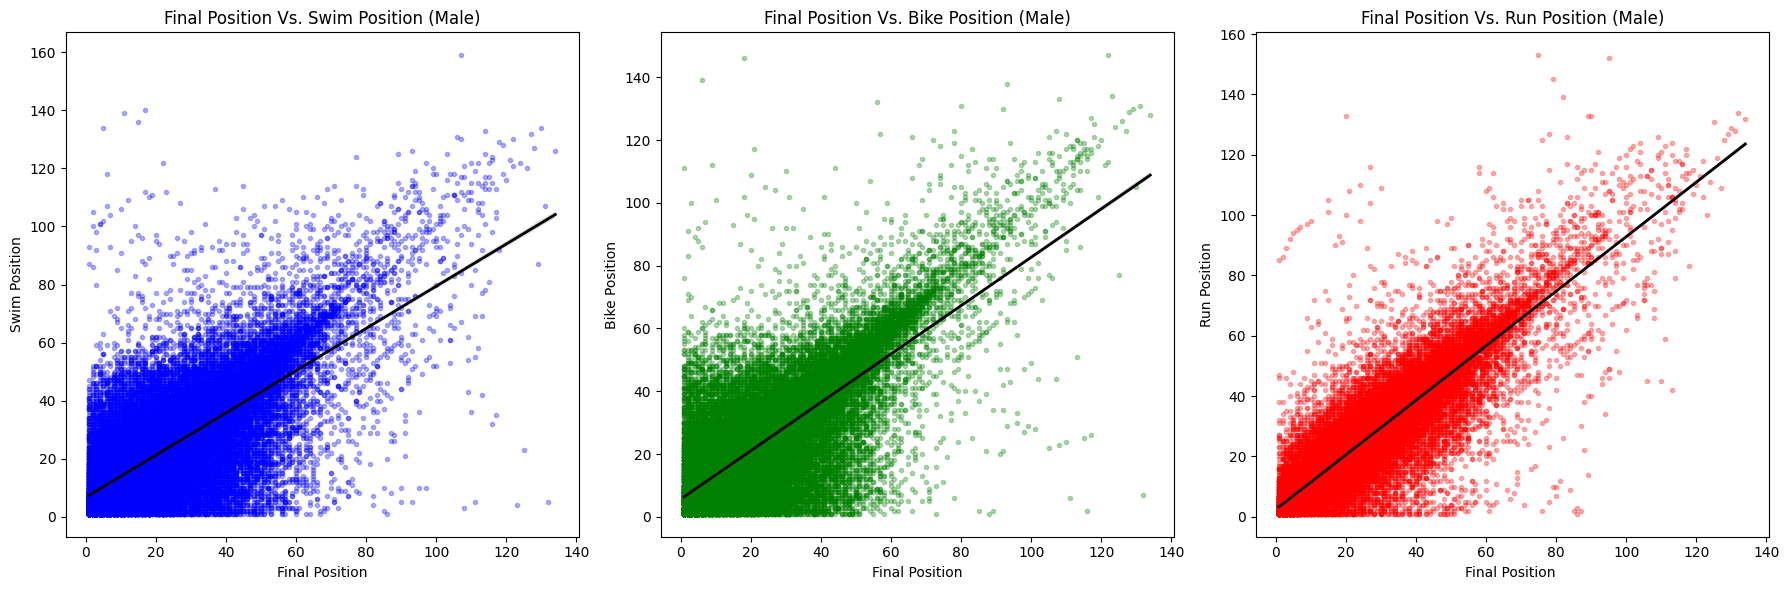

In [37]:
def plot_positions_with_regression(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Grafico 1: Posizione finale vs Posizione nuoto con zona di confidenza colorata
    sns.regplot(
        x='position',
        y='swim_position',
        data=df,
        ax=axes[0],
        ci=95,
        marker=".",
        scatter_kws={'color': 'blue', 'alpha': 0.3},  # Colore dei punti
        line_kws={'color': 'black', 'lw': 2},  # Colore della linea di regressione
        scatter=True
    )
    axes[0].set_title(f'Final Position Vs. Swim Position {sex}')
    axes[0].set_xlabel('Final Position')
    axes[0].set_ylabel('Swim Position')

    # Grafico 2: Posizione finale vs Posizione ciclismo con zona di confidenza colorata
    sns.regplot(
        x='position',
        y='bike_position',
        data=df,
        ax=axes[1],
        ci=95,
        marker=".",
        scatter_kws={'color': 'green', 'alpha': 0.3},  # Colore dei punti
        line_kws={'color': 'black', 'lw': 2},  # Colore della linea di regressione
        scatter=True
    )
    axes[1].set_title(f'Final Position Vs. Bike Position {sex}')
    axes[1].set_xlabel('Final Position')
    axes[1].set_ylabel('Bike Position')

    # Grafico 3: Posizione finale vs Posizione corsa con zona di confidenza colorata
    sns.regplot(
        x='position',
        y='run_position',
        data=df,
        ax=axes[2],
        ci=95,
        marker=".",
        scatter_kws={'color': 'red', 'alpha': 0.3},  # Colore dei punti
        line_kws={'color': 'black', 'lw': 2},  # Colore della linea di regressione
        scatter=True
    )
    axes[2].set_title(f'Final Position Vs. Run Position {sex}')
    axes[2].set_xlabel('Final Position ')
    axes[2].set_ylabel('Run Position')

    plt.tight_layout()
    plt.show()

# Utilizzo della funzione
plot_positions_with_regression(df_filtered)


In [38]:
def regression(df, degree=[1, 5]):
    results = {}

    # Define the independent variable
    X = df['position'].values.reshape(-1, 1)

    # Define the dependent variables
    y_vars = ['swim_position', 'bike_position', 'run_position']

    # Iterate over each dependent variable
    for y_var in y_vars:
        y = df[y_var].values
        results[y_var] = {}

        # Iterate over the range of degrees
        for deg in range(degree[0], degree[1] + 1):
            # Polynomial transformation for degrees > 1
            if deg > 1:
                poly = PolynomialFeatures(degree=deg)
                X_poly = poly.fit_transform(X)
                model = LinearRegression()
                model.fit(X_poly, y)
                y_pred = model.predict(X_poly)
                intercept = model.intercept_
                coefs = model.coef_
                r_squared = r2_score(y, y_pred)

                # Create the polynomial equation string
                equation = f"{y_var} = {intercept:.4f}"
                terms = [f"{coefs[i]:+.4f}*x^{i}" for i in range(1, len(coefs))]
                equation += " " + " ".join(terms)
            else:
                # Linear regression (deg=1)
                model = LinearRegression()
                model.fit(X, y)
                y_pred = model.predict(X)
                intercept = model.intercept_
                slope = model.coef_[0]
                r_squared = r2_score(y, y_pred)
                equation = f"{y_var} = {intercept:.4f} + {slope:.4f}*x"

            # Store results for this variable and degree
            results[y_var][f"degree_{deg}"] = {
                'equation': equation,
                'r_squared': r_squared
            }

    return results

# Example usage
# Assuming df is your DataFrame with 'position', 'swim_position', 'bike_position', and 'run_position' columns
results = regression(df_filtered, degree=[1, 5])

# Print the results
for y_var, degrees in results.items():
    print(f"Results for {y_var}:")
    for deg, info in degrees.items():
        print(f"  {deg}: {info['equation']} (R^2 = {info['r_squared']:.4f})")
    print("\n")


Results for swim_position:
  degree_1: swim_position = 6.6873 + 0.7272*x (R^2 = 0.5036)
  degree_2: swim_position = 8.0900 +0.5964*x^1 +0.0019*x^2 (R^2 = 0.5065)
  degree_3: swim_position = 8.1469 +0.5878*x^1 +0.0022*x^2 -0.0000*x^3 (R^2 = 0.5065)
  degree_4: swim_position = 7.1356 +0.8130*x^1 -0.0091*x^2 +0.0002*x^3 -0.0000*x^4 (R^2 = 0.5073)
  degree_5: swim_position = 7.0657 +0.8341*x^1 -0.0106*x^2 +0.0002*x^3 -0.0000*x^4 +0.0000*x^5 (R^2 = 0.5073)


Results for bike_position:
  degree_1: bike_position = 5.6574 + 0.7701*x (R^2 = 0.5738)
  degree_2: bike_position = 8.0067 +0.5511*x^1 +0.0032*x^2 (R^2 = 0.5820)
  degree_3: bike_position = 9.0672 +0.3908*x^1 +0.0080*x^2 -0.0000*x^3 (R^2 = 0.5831)
  degree_4: bike_position = 8.3030 +0.5609*x^1 -0.0005*x^2 +0.0001*x^3 -0.0000*x^4 (R^2 = 0.5836)
  degree_5: bike_position = 7.9032 +0.6815*x^1 -0.0091*x^2 +0.0003*x^3 -0.0000*x^4 +0.0000*x^5 (R^2 = 0.5837)


Results for run_position:
  degree_1: run_position = 2.4509 + 0.9039*x (R^2 = 0.7937

In [39]:
def get_winners_positions(df):
    # Filtra per ottenere solo i vincitori
    winners = df[df['position'] == 1]
    return winners[['swim_position', 'bike_position', 'run_position']]


In [40]:
def descriptive_statistics(winners):
    stats = winners.describe()
    return stats


In [41]:
def plot_winners_positions(winners):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=winners)
    plt.title(f"Distribution of the discipline position for winner {sex}")
    plt.xlabel('Discipline')
    plt.ylabel('Position')
    plt.ylim(0, 30)
    plt.yticks(np.arange(1, 30 + 1, 1))
    plt.show()


In [42]:
def compare_disciplines(winners):
    swim_positions = winners['swim_position']
    bike_positions = winners['bike_position']
    run_positions = winners['run_position']

    # Test di Friedman per confrontare le posizioni nelle tre discipline
    stat, p_value = friedmanchisquare(swim_positions, bike_positions, run_positions)

    return stat, p_value


Statistiche Descrittive:
        swim_position  bike_position  run_position
count    1317.000000    1317.000000   1317.000000
mean        7.793470       8.806378      2.963554
std         8.842158      11.027309      4.671118
min         1.000000       1.000000      1.000000
25%         2.000000       2.000000      1.000000
50%         5.000000       4.000000      1.000000
75%        11.000000      11.000000      3.000000
max        93.000000     111.000000     85.000000


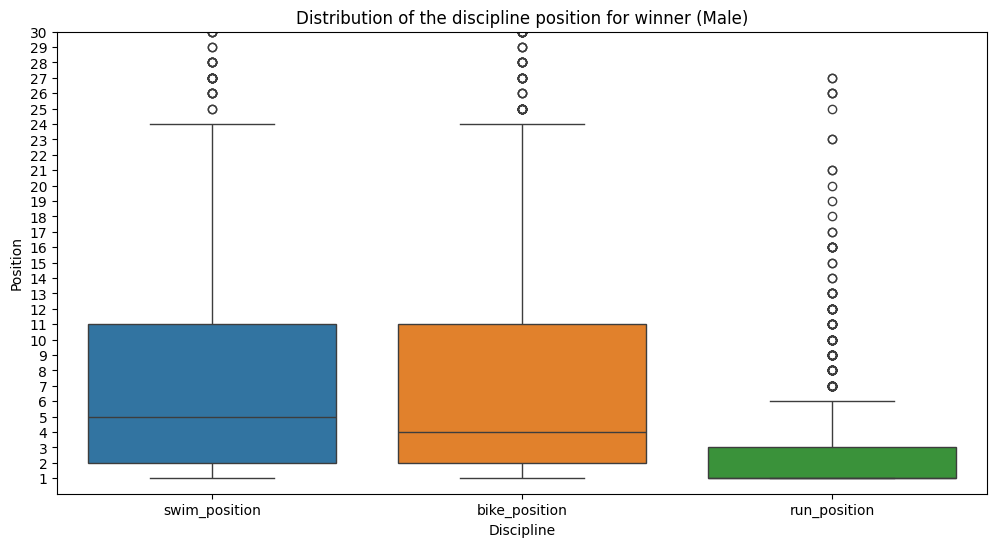

Test di Friedman: stat=511.77338296882283, p_value=7.4100629231247625e-112
Interpretation: Very Good - There is a highly significant difference between the disciplines.


In [43]:
# 1. Isolare i dati dei vincitori
winners_positions = get_winners_positions(df_filtered)

# 2. Calcolare le statistiche descrittive
statistics = descriptive_statistics(winners_positions)
print("Statistiche Descrittive:\n", statistics)

# 3. Visualizzare i dati
plot_winners_positions(winners_positions)

# 4. Confronto statistico


stat, p_value = compare_disciplines(winners_positions)
print(f"Test di Friedman: stat={stat}, p_value={p_value}")

if p_value < 0.01:
    print("Interpretation: Very Good - There is a highly significant difference between the disciplines.")
elif 0.01 <= p_value < 0.05:
    print("Interpretation: Good - There is a significant difference between the disciplines.")
elif 0.05 <= p_value < 0.10:
    print("Interpretation: Moderate - There is a marginal difference between the disciplines.")
elif 0.10 <= p_value < 0.20:
    print("Interpretation: Poor - There is little to no significant difference between the disciplines.")
else:
    print("Interpretation: Very Poor - There is no significant difference between the disciplines.")


# Interpretation for the winner of the race
The winner of the race reach:
- Average swim position: 4,5
- Average bike position: 3,9
- Average run position: 2,1

The first interpretation: if you want to win a triathoon race in élite level need to exit from the water in the first 5 position, reach the T2 in front group and perform the best run time. But this is only for the winner

Also we want to know for the podium (1, 2, 3) and over the podium (from 4 to 10) and discover what is the position and performance

#Interpretation Scale for P-Value
Very Good (Highly Significant Difference)

##p-value: Less than 0.01
- Interpretation: There is a very strong evidence that the rankings across the groups differ. This suggests that the performance in different disciplines (e.g., swimming, cycling, running) has a significant and consistent impact on the outcome.
- Example: "The Friedman test indicates a highly significant difference between the disciplines, suggesting that at least one discipline is consistently more influential in determining winners' positions."
Good (Significant Difference)

## p-value: Between 0.01 and 0.05
- Interpretation: There is strong evidence that the rankings across the groups differ. This suggests that differences between disciplines are likely meaningful and affect the outcome.
- Example: "The test shows a significant difference between the disciplines, implying that performance in at least one discipline likely contributes more to the overall result."
Moderate (Marginal Difference)

## p-value: Between 0.05 and 0.10
- Interpretation: There is some evidence that the rankings across the groups differ, but the difference is not as strong. The influence of different disciplines may be present but less pronounced.
- Example: "There is a marginal difference between disciplines, indicating that their impact on the outcome might be there, but it is not as strong."
Poor (Little to No Difference)

## p-value: Between 0.10 and 0.20
- Interpretation: There is weak evidence for differences between the groups. The performance in different disciplines may have little to no significant effect on the outcome.
- Example: "The results suggest little difference between disciplines, implying that no single discipline has a significant impact on the overall outcome."
Very Poor (No Significant Difference)

## p-value: Greater than 0.20
- Interpretation: There is no significant evidence that the rankings differ between groups. The disciplines likely do not have a meaningful impact on the overall result.
- Example: "The Friedman test shows no significant difference between the disciplines, suggesting that each discipline contributes similarly to the final result."

# Definition of the Friedman Test

The Friedman test is a non-parametric statistical test used to detect differences in treatments across multiple test attempts. It is an alternative to the repeated-measures ANOVA when the assumption of normality is violated. The test is particularly useful when you have three or more related samples, such as measurements taken on the same subjects under different conditions.

### Key Points:

- **Purpose**: The Friedman test evaluates whether there are significant differences between the groups based on ranks.
- **Data Type**: It works with ordinal data or non-normally distributed continuous data.
- **Assumptions**: The test assumes that the data is paired and that there is no interaction between the groups.

### Interpreting the Friedman Test:

- **p-value**: The primary output of the Friedman test is the p-value.
  - If the **p-value** is **less than 0.05**, it suggests that there are statistically significant differences between the groups.
  - If the **p-value** is **greater than 0.05**, it suggests that there are no statistically significant differences between the groups.

- **Chi-Square Statistic (Q)**: The Friedman test also provides a chi-square statistic.
  - The larger the **Q** value, the greater the likelihood that the observed ranks differ significantly from what would be expected if there were no differences between the groups.

### Approximate Values for a "Good" Result:

- **p-value < 0.05**: Indicates a significant difference between groups, which might be considered "good" if you're looking for evidence that the treatments or conditions are not equal.
- **Effect Size (if reported)**: An effect size (e.g., Kendall's W) closer to 1 indicates a stronger effect, meaning the differences between groups are more pronounced.

In summary, a "good" result from the Friedman test, indicating significant differences between your conditions or groups, would typically involve a p-value less than 0.05 and a high chi-square statistic.

In [44]:
def get_positions_in_range(df, start_position, end_position):
    # Filtra il DataFrame per ottenere solo le posizioni finali all'interno dell'intervallo specificato
    filtered_positions = df[(df['position'] >= start_position) & (df['position'] <= end_position)]
    return filtered_positions[['swim_position', 'bike_position', 'run_position']]


In [45]:
def descriptive_statistics(positions):
    stats = positions.describe()
    return stats


In [83]:
def plot_positions_in_range(positions, start_position, end_position):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=positions)
    # Distribution of the discipline position for final position
    plt.title(f'Distribution of the discipline position for final position {start_position}-{end_position} {sex}')
    plt.ylim(0, 40)
    plt.xlabel('Discipline')
    plt.ylabel('Position')
    plt.yticks(np.arange(1, 40 + 1, 1))
    plt.show()


In [47]:
def compare_disciplines(positions):
    swim_positions = positions['swim_position']
    bike_positions = positions['bike_position']
    run_positions = positions['run_position']

    # Friedman test to campare the discipline
    stat, p_value = friedmanchisquare(swim_positions, bike_positions, run_positions)

    if p_value < 0.01:
        print("Interpretation: Very Good - There is a highly significant difference between the disciplines.")
    elif 0.01 <= p_value < 0.05:
        print("Interpretation: Good - There is a significant difference between the disciplines.")
    elif 0.05 <= p_value < 0.10:
        print("Interpretation: Moderate - There is a marginal difference between the disciplines.")
    elif 0.10 <= p_value < 0.20:
        print("Interpretation: Poor - There is little to no significant difference between the disciplines.")
    else:
        print("Interpretation: Very Poor - There is no significant difference between the disciplines.")

    return stat, p_value


In [48]:
def generate_descriptive_sentence(metric, value, percentage):
    return f"Position {metric} is {int(value)}, and {percentage:.2f}% of the athlete obtain this position"

def calculate_percentages(positions, value):
    # Calcola la percentuale di persone che hanno ottenuto esattamente quella posizione
    return (positions == value).mean() * 100

def calculate_above_50th_percentile(positions, median_value):
    # Conta quante persone si sono piazzate oltre il 50° percentile (mediana)
    above_50th = positions[positions > median_value].count()
    total = positions.count()
    percentage = (above_50th / total) * 100
    return above_50th, percentage

def analyze_positions_range(df, start_position, end_position):
    # 1. Filtrare i dati in base all'intervallo di posizioni specificato
    positions_in_range = get_positions_in_range(df, start_position, end_position)

    # 2. Calcolare le statistiche descrittive
    statistics = descriptive_statistics(positions_in_range)
    print("Descriptive statistic:\n", statistics)

    # 3. Visualizzare i dati
    plot_positions_in_range(positions_in_range, start_position, end_position)

    # 4. Confronto statistico
    stat, p_value = compare_disciplines(positions_in_range)
    print(f"Friedman Test: stat={stat}, p_value={p_value}")

    if p_value < 0.01:
        print("Interpretation: Very Good - There is a highly significant difference between the disciplines.")
    elif 0.01 <= p_value < 0.05:
        print("Interpretation: Good - There is a significant difference between the disciplines.")
    elif 0.05 <= p_value < 0.10:
        print("Interpretation: Moderate - There is a marginal difference between the disciplines.")
    elif 0.10 <= p_value < 0.20:
        print("Interpretation: Poor - There is little to no significant difference between the disciplines.")
    else:
        print("Interpretation: Very Poor - There is no significant difference between the disciplines.")

    # 5. Calcolare le percentuali per ciascuna metrica statistica e generare frasi descrittive
    for col in ['swim_position', 'bike_position', 'run_position']:
        print(f"\nDescriptive {col}:")
        for metric in ['min', '25%', '50%', '75%', 'max', 'mean']:
            value = statistics.at[metric, col]
            # Arrotonda la media a un numero intero
            if metric == 'mean':
                value = round(value)
            percentage = calculate_percentages(positions_in_range[col], value)
            sentence = generate_descriptive_sentence(metric, value, percentage)
            print(sentence)

        # 6. Calcolare il numero e la percentuale delle persone piazzate oltre il 50° percentile
        median_value = round(statistics.at['50%', col])
        above_50th, percentage_above_50th = calculate_above_50th_percentile(positions_in_range[col], median_value)
        print(f"The position over 50% have {above_50th} athlete and are {percentage_above_50th:.2f}%")


Descriptive statistic:
        swim_position  bike_position  run_position
count    8770.000000    8770.000000   8770.000000
mean       12.426112      12.172292      8.628392
std        10.417921      10.142168      5.715056
min         1.000000       1.000000      1.000000
25%         5.000000       5.000000      5.000000
50%         9.000000       9.000000      8.000000
75%        16.000000      16.000000     10.000000
max       134.000000     139.000000     98.000000


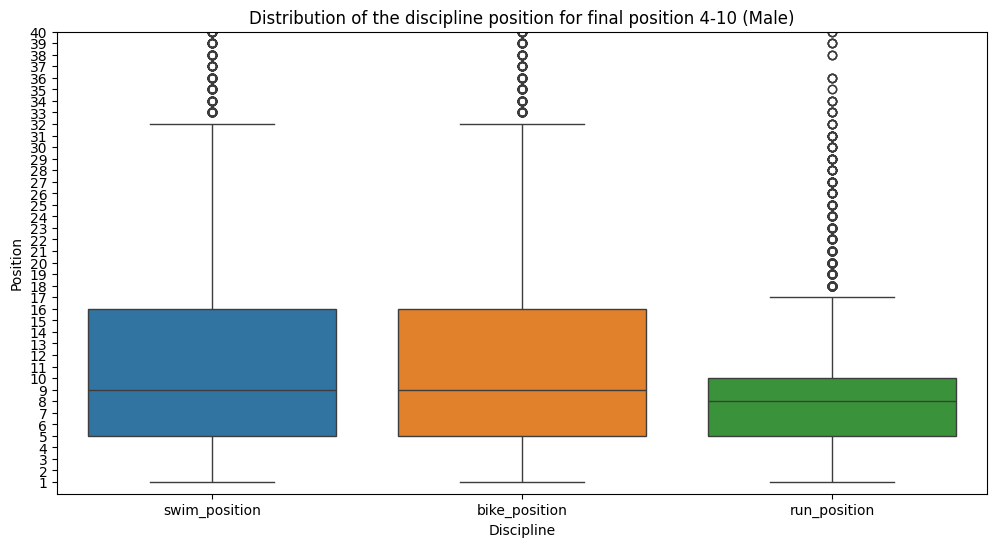

Interpretation: Very Good - There is a highly significant difference between the disciplines.
Friedman Test: stat=485.8510541087441, p_value=3.153436476142305e-106
Interpretation: Very Good - There is a highly significant difference between the disciplines.

Descriptive swim_position:
Position min is 1, and 4.28% of the athlete obtain this position
Position 25% is 5, and 6.04% of the athlete obtain this position
Position 50% is 9, and 5.96% of the athlete obtain this position
Position 75% is 16, and 2.52% of the athlete obtain this position
Position max is 134, and 0.01% of the athlete obtain this position
Position mean is 12, and 3.88% of the athlete obtain this position
The position over 50% have 4348 athlete and are 49.58%

Descriptive bike_position:
Position min is 1, and 4.04% of the athlete obtain this position
Position 25% is 5, and 6.56% of the athlete obtain this position
Position 50% is 9, and 6.09% of the athlete obtain this position
Position 75% is 16, and 2.35% of the athl

In [84]:
#analyze_positions_range(df_filtered, 1, 1)
#analyze_positions_range(df_filtered, 1, 3)
analyze_positions_range(df_filtered, 4, 10)


# For winner interpetation

The  winner of the race reach:
- Average swim position:
- Average bike position:
- Average run position:

# From 1 to 3 interpretation

The podium of the race reach:
- Average swim position: 5,3
- Average bike position: 4,7
- Average run position: 3,2

The first interpretation: if you want to win a triathoon race in élite level need to exit from the water in the first 5 position, reach the T2 in front group and perform the best run time.

# From 4 to 10 interpretation

after the 4th position of the race reach:
- Average swim position: 9,2
- Average bike position: 8,3
- Average run position: 7,8

The first interpretation: after the podium to reach a good position (even good quantity of points) the athlete needs to go aout of the water in 10 position, reach T2 in teh first 10 position and run faster with maximun the 8 best time

## We want to understand how many athelte win the race and reach the first position in swim, bike and run

In [50]:
train_df = train_df.loc[~(train_df == 0).any(axis=1)]
train_df

,date_of_event,event_date,position,swim_time,T1_time,bike_time,T2_time,run_time,total_time,swim_position,t1_position,bike_position,t2_position,run_position
215,1990.0,1990-09-15,1,1221.0,99.0,3379.0,38.0,1960.0,6697.0,22.0,18.0,19.0,17.0,1.0
216,1990.0,1990-09-15,2,1136.0,94.0,3457.0,37.0,2034.0,6760.0,3.0,6.0,45.0,12.0,4.0
217,1990.0,1990-09-15,3,1220.0,112.0,3378.0,34.0,2023.0,6767.0,21.0,56.0,17.0,5.0,3.0
218,1990.0,1990-09-15,4,1226.0,103.0,3378.0,38.0,2037.0,6782.0,25.0,29.0,18.0,18.0,5.0
219,1990.0,1990-09-15,5,1225.0,100.0,3380.0,31.0,2056.0,6792.0,24.0,22.0,20.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45894,2024.0,2024-05-25,45,1132.0,34.0,3169.0,22.0,2088.0,6444.0,27.0,16.0,31.0,26.0,48.0
45895,2024.0,2024-05-25,46,1142.0,34.0,3333.0,23.0,1930.0,6460.0,37.0,18.0,49.0,36.0,37.0
45896,2024.0,2024-05-25,47,1157.0,37.0,3257.0,25.0,2020.0,6495.0,42.0,47.0,44.0,46.0,44.0
45897,2024.0,2024-05-25,48,1158.0,35.0,3258.0,25.0,2032.0,6505.0,44.0,30.0,45.0,47.0,47.0


In [51]:
# Convert column in int to have correct data
train_df['position'] = train_df['position'].astype(int)
train_df['swim_position'] = train_df['swim_position'].astype(int)
train_df['bike_position'] = train_df['bike_position'].astype(int)
train_df['run_position'] = train_df['run_position'].astype(int)

# filering row for 1 position in swim, bike, run
filtered_df = train_df[(train_df['position'] == 1) &
                       (train_df['swim_position'] == 1) &
                       (train_df['bike_position'] == 1) &
                       (train_df['run_position'] == 1)]

# count number of row for that condition
count = filtered_df.shape[0]

percentage_overall = round((count/unique_race)*100, 2)


print(f"Number of times the athlete who finished 1st overall also finished 1st in swim, bike, and run: {count}\n and this is the {percentage_overall}% of the race considered for {sex}")



Number of times the athlete who finished 1st overall also finished 1st in swim, bike, and run: 10
 and this is the 0.95% of the race considered for (Male)


<ipython-input-51-e2a8bfec1870>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['position'] = train_df['position'].astype(int)
<ipython-input-51-e2a8bfec1870>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['swim_position'] = train_df['swim_position'].astype(int)
<ipython-input-51-e2a8bfec1870>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

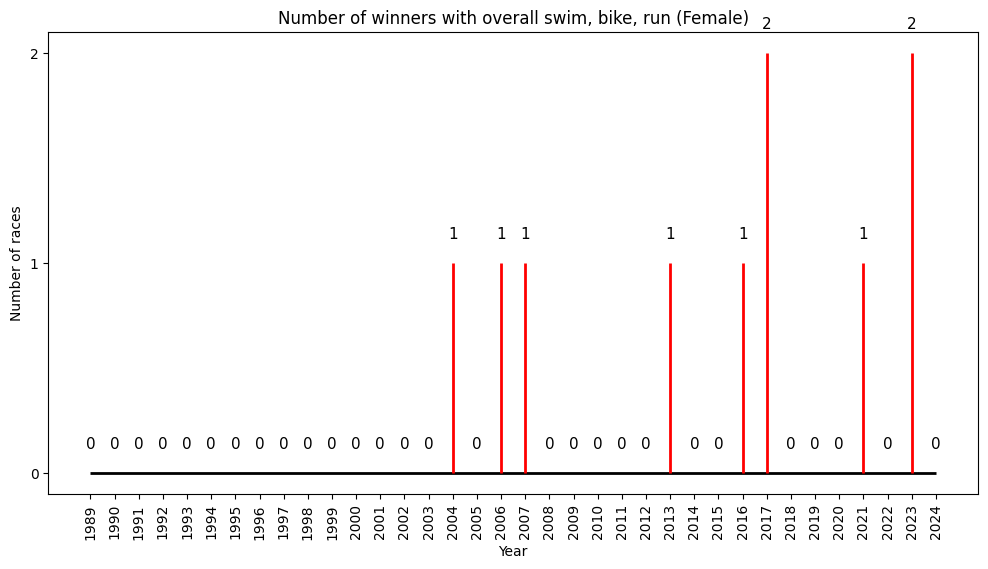

In [52]:
# make interval from 1989 to 2024
full_year_range = pd.Series(range(1989, 2025))

# numebr of event for missing data
events_per_year = filtered_df['event_date'].dt.year.value_counts().reindex(full_year_range, fill_value=0).sort_index()

# chart cration
plt.figure(figsize=(12, 6))

# horizontalline black
plt.hlines(y=0, xmin=1989, xmax=2024, color='black', linewidth=2)

# vertical line
for year, count in events_per_year.items():
    plt.vlines(x=year, ymin=0, ymax=count, color='red', linewidth=2)
    plt.text(year, count + 0.1, str(count), ha='center', va='bottom', fontsize=11, color='black')

# set x and y axis
plt.xticks(full_year_range, rotation=90)
plt.yticks(range(0, events_per_year.max() + 1))
plt.xlabel('Year')
plt.ylabel('Number of races')
plt.title(f'Number of winners with overall swim, bike, run (Female)')
plt.grid(False)

plt.show()


In [53]:
filtered_df.head(10)

,date_of_event,event_date,position,swim_time,T1_time,bike_time,T2_time,run_time,total_time,swim_position,t1_position,bike_position,t2_position,run_position
13704,2004.0,2004-05-09,1,1305.0,200.0,4727.0,161.0,2185.0,8576.0,1,1.0,1,1.0,1
19224,2006.0,2006-09-02,1,1116.0,385.0,295.0,868.0,4869.0,7531.0,1,17.0,1,2.0,1
21644,2007.0,2007-07-15,1,992.0,39.0,3570.0,30.0,1967.0,6600.0,1,17.0,1,13.0,1
34701,2013.0,2013-11-16,1,1094.0,19.0,4092.0,30.0,2069.0,7304.0,1,2.0,1,3.0,1
38233,2016.0,2016-03-20,1,1252.0,91.0,3799.0,57.0,2049.0,7248.0,1,2.0,1,4.0,1
39317,2017.0,2017-03-19,1,981.0,33.0,3887.0,27.0,2228.0,7156.0,1,8.0,1,4.0,1
39810,2017.0,2017-06-25,1,1066.0,62.0,3170.0,39.0,2056.0,6520.0,1,5.0,1,1.0,1
43247,2021.0,2021-07-25,1,1158.0,115.0,3401.0,34.0,2009.0,6719.0,1,1.0,1,2.0,1
45482,2023.0,2023-10-13,1,1188.0,76.0,3662.0,72.0,2175.0,7170.0,1,4.0,1,3.0,1
45536,2023.0,2023-10-15,1,1088.0,65.0,3366.0,18.0,1942.0,6481.0,1,38.0,1,3.0,1


## sono arrivato qua
Determining the most influent part of the race using classic statistic with correlation

In [72]:
def analyze_influence_statistically(df, start_position, end_position):
    # Filtrare i dati in base all'intervallo di posizioni specificato
    filtered_df = df[(df['position'] >= start_position) & (df['position'] <= end_position)]

    # Calcolare le statistiche descrittive per swim, bike, run
    swim_stats = filtered_df['swim_time'].describe()
    bike_stats = filtered_df['bike_time'].describe()
    run_stats = filtered_df['run_time'].describe()

    # Calcolare la correlazione tra ciascuna disciplina e la posizione finale
    correlations = filtered_df[['swim_time', 'bike_time', 'run_time', 'position']].corr()['position'][:-1]

    # Stampare i risultati
    print(f"Statistical Analysis from {start_position} to {end_position}:\n")
    print("Descriptive statistic for swim_time:\n", swim_stats)
    print("\nDescriptive statistic for bike_time:\n", bike_stats)
    print("\nDescriptive statistic for run_time:\n", run_stats)
    print("\nCorrelation for the final position:\n", correlations)

    # Determinare la disciplina più influente
    most_influential_corr = correlations.idxmin()
    print(f"\nThe most influential discipline for this position range is: {most_influential_corr}")

# Esempio di utilizzo per il primo posto
#analyze_influence_statistically(df_filtered, 1, 1)

# Esempio di utilizzo per il range 1-3
analyze_influence_statistically(df_filtered, 1, 3)

# Esempio di utilizzo per il range 4-10
#analyze_influence_statistically(df_filtered, 4, 10)


Statistical Analysis from 1 to 3:

Descriptive statistic for swim_time:
 count    3957.000000
mean     1007.140510
std       410.975173
min         0.000000
25%      1050.000000
50%      1114.000000
75%      1173.000000
max      6884.000000
Name: swim_time, dtype: float64

Descriptive statistic for bike_time:
 count    3957.000000
mean     3147.607278
std      1231.507865
min         0.000000
25%      3323.000000
50%      3524.000000
75%      3723.000000
max      5129.000000
Name: bike_time, dtype: float64

Descriptive statistic for run_time:
 count     3957.000000
mean      1753.342937
std        717.328303
min          0.000000
25%       1845.000000
50%       1927.000000
75%       2030.000000
max      10017.000000
Name: run_time, dtype: float64

Correlation for the final position:
 swim_time    0.018751
bike_time    0.007975
run_time     0.018017
Name: position, dtype: float64

The most influential discipline for this position range is: bike_time


# Determining the most influent pert of the race using classic statistic with linear regression

In [73]:
def analyze_influence_statistically(df, start_position, end_position):
    # Filter the data based on the specified position range
    filtered_df = df[(df['position'] >= start_position) & (df['position'] <= end_position)]

    # Define the independent variables (swim_time, bike_time, run_time) and the dependent variable (position)
    X = filtered_df[['swim_time', 'bike_time', 'run_time']]
    y = filtered_df['position']

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients for each discipline
    coefficients = pd.Series(model.coef_, index=X.columns)

    # Print the results
    print(f"Statistical analysis using Linear Regression for final positions between {start_position} and {end_position}:\n")
    print("Linear Regression Coefficients for each discipline:\n", round(coefficients, 7))

    # Determine the most influential discipline
    most_influential_linear = coefficients.idxmin()  # Lower coefficient (more negative) indicates a stronger influence
    print(f"\nThe most influential discipline for this position range is: {most_influential_linear}")

# Example usage for the range for the winner
#analyze_influence_statistically(df_filtered, 1, 1)

# Example usage for the range 1-3
analyze_influence_statistically(df_filtered, 1, 3)

# Example usage for the range 4-10
#analyze_influence_statistically(df_filtered, 4, 10)


Statistical analysis using Linear Regression for final positions between 1 and 3:

Linear Regression Coefficients for each discipline:
 swim_time    0.000059
bike_time   -0.000022
run_time     0.000024
dtype: float64

The most influential discipline for this position range is: bike_time


# Determining the most influent pert of the race using classic statistic with polynomial regression

In [74]:
def analyze_influence_statistically(df, start_position, end_position, degree=2):
    # Filter the data based on the specified position range
    filtered_df = df[(df['position'] >= start_position) & (df['position'] <= end_position)]

    # Define the independent variables (swim_time, bike_time, run_time) and the dependent variable (position)
    X = filtered_df[['swim_time', 'bike_time', 'run_time']]
    y = filtered_df['position']

    # Apply polynomial features to the independent variables
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Fit a linear regression model on the polynomial features
    model = LinearRegression()
    model.fit(X_poly, y)

    # Extract the coefficients (for interpretation, use the original feature names)
    feature_names = poly.get_feature_names_out(X.columns)
    coefficients = pd.Series(model.coef_, index=feature_names)

    # Print the results
    print(f"Statistical analysis using Polynomial Regression (degree={degree}) for final positions between {start_position} and {end_position}:\n")
    print("Polynomial Regression Coefficients for each discipline:\n", coefficients)

    # Determine the most influential discipline
    # Sum coefficients for each original discipline feature
    influence = {
        'swim_time': coefficients.filter(like='swim_time').sum(),
        'bike_time': coefficients.filter(like='bike_time').sum(),
        'run_time': coefficients.filter(like='run_time').sum()
    }
    most_influential = min(influence, key=influence.get)

    print(f"\nThe most influential discipline for this position range is: {most_influential}")
    print(f"\nTotal influence: {influence}")

# Example usage for the range for winner
#analyze_influence_statistically(df_filtered, 1, 1, degree=2)

# Example usage for the range 1-3
analyze_influence_statistically(df_filtered, 1, 3, degree=2)

# Example usage for the range 4-10
#analyze_influence_statistically(df_filtered, 4, 10, degree=2)


Statistical analysis using Polynomial Regression (degree=2) for final positions between 1 and 3:

Polynomial Regression Coefficients for each discipline:
 swim_time              2.547483e-04
bike_time             -3.699545e-04
run_time               1.456510e-04
swim_time^2           -2.420983e-08
swim_time bike_time   -6.241555e-09
swim_time run_time    -1.668159e-08
bike_time^2            2.964708e-08
bike_time run_time     9.089341e-08
run_time^2            -3.972227e-08
dtype: float64

The most influential discipline for this position range is: bike_time

Total influence: {'swim_time': 0.00025470120260402885, 'bike_time': -0.0003698401565896812, 'run_time': 0.00014568549748018454}


# Determining the most influent part of the race using machine learning (sklearn)

In [75]:
def analyze_influence_ml(df, start_position, end_position):
    # Create a target column: 1 if the final position is within the specified range, otherwise 0
    df['target'] = np.where((df['position'] >= start_position) & (df['position'] <= end_position), 1, 0)

    # Select the features and the target
    X = df[['swim_time', 'bike_time', 'run_time']]
    y = df['target']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    # Handle case with only one class in y_test
    labels = np.unique(y_test)
    target_names = ['Other Positions', 'Top Positions'][:len(labels)]

    # Generate the classification report
    report = classification_report(y_test, y_pred, target_names=target_names, labels=labels, output_dict=True)

    # Extract precision, recall, and f1-score for the positive class (Top Positions)
    precision = report[target_names[-1]]['precision'] if len(labels) > 1 else "NaN"
    recall = report[target_names[-1]]['recall'] if len(labels) > 1 else "NaN"
    f1_score = report[target_names[-1]]['f1-score'] if len(labels) > 1 else "NaN"

    # Extract coefficients for each discipline
    coefficients = pd.Series(model.coef_[0], index=X.columns)

    # Determine the most influential discipline
    most_influential = coefficients.idxmin()

    # Return metrics and most influential discipline
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'most_influential': most_influential
    }

# Example usage for the winner
#ml_results = analyze_influence_ml(df_filtered, 1, 1)

# Example usage for the range 1-3
ml_results = analyze_influence_ml(df_filtered, 1, 3)

# Example usage for the range 4-10
#ml_results = analyze_influence_ml(df_filtered, 4, 10)

# Print the results
print(f"Model Accuracy: {ml_results['accuracy']}")
print(f"Model Precision: {ml_results['precision']}")
print(f"Model Recall: {ml_results['recall']}")
print(f"Model F1-Score: {ml_results['f1_score']}")
print(f"Most Influential Discipline: {ml_results['most_influential']}")


<ipython-input-75-9ae8ec527c84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where((df['position'] >= start_position) & (df['position'] <= end_position), 1, 0)


Model Accuracy: 0.912367700392273
Model Precision: 0.0
Model Recall: 0.0
Model F1-Score: 0.0
Most Influential Discipline: run_time


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Determining the most influent part of the race using machine learning (tensorflow)

In [76]:
def analyze_influence_tensorflow(df, start_position, end_position):
    # Create a target column: 1 if the final position is within the specified range, otherwise 0
    df['target'] = np.where((df['position'] >= start_position) & (df['position'] <= end_position), 1, 0)

    # Select the features and the target
    X = df[['swim_time', 'bike_time', 'run_time']].values
    y = df['target'].values

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create the TensorFlow model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    accuracy = accuracy_score(y_test, y_pred)

    # Handle case with only one class in y_test
    labels = np.unique(y_test)
    target_names = ['Other Positions', 'Top Positions'][:len(labels)]

    report = classification_report(y_test, y_pred, target_names=target_names, labels=labels, output_dict=True)

    precision = report[target_names[-1]]['precision'] if len(labels) > 1 else "NaN"
    recall = report[target_names[-1]]['recall'] if len(labels) > 1 else "NaN"
    f1_score = report[target_names[-1]]['f1-score'] if len(labels) > 1 else "NaN"

    # Extract feature weights to understand the influence of each discipline
    weights = model.layers[0].get_weights()[0].flatten()
    influence = dict(zip(['swim_time', 'bike_time', 'run_time'], weights))
    most_influential = min(influence, key=influence.get)

    # Print results (optional, can be removed if you only want to return the data)
    print(f"TensorFlow Model Analysis for final positions between {start_position} and {end_position}:\n")
    print(f"Model Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print(f"Feature Weights: {influence}")
    print(f"\nThe most influential discipline for this position range is: {most_influential}")

    # Return metrics and most influential discipline
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'most_influential': most_influential
    }

# Example usage for the winner
#tf_results = analyze_influence_tensorflow(df_filtered, 1, 1)

# Example usage for the range 1-3
tf_results = analyze_influence_tensorflow(df_filtered, 1, 3)

# Example usage for the range 4-10
#tf_results = analyze_influence_tensorflow(df_filtered, 4, 10)

# Print the results
print(f"Model Accuracy: {tf_results['accuracy']}")
print(f"Model Precision: {tf_results['precision']}")
print(f"Model Recall: {tf_results['recall']}")
print(f"Model F1-Score: {tf_results['f1_score']}")
print(f"Most Influential Discipline: {tf_results['most_influential']}")


<ipython-input-76-dbc0374df83c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where((df['position'] >= start_position) & (df['position'] <= end_position), 1, 0)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TensorFlow Model Analysis for final positions between 1 and 3:

Model Accuracy: 0.9127

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     12327
           1       0.83      0.00      0.01      1184

    accuracy                           0.91     13511
   macro avg       0.87      0.50      0.48     13511
weighted avg       0.91      0.91      0.87     13511

Feature Weights: {'swim_time': -0.005621635, 'bike_time': -0.0045196107, 'run_time': 0.014709113}

The most influential discipline for this position range is: swim_time
Model Accuracy: 0.9126637554585153
Model Precision: 0.8333333333333334
Model Recall: 0.004222972972972973
Model F1-Score: 0.008403361344537815
Most Influential Discipline: swim_time


### Model Evaluation Metrics

1. **Precision**:
   - **Definition**: Precision measures the proportion of correctly predicted positive instances out of all instances predicted as positive by the model.
   - **Formula**: `Precision = TP / (TP + FP)`
   - **Interpretation**: High precision means that most of the positive predictions made by the model are correct (few false positives).

2. **Recall (Sensitivity or True Positive Rate)**:
   - **Definition**: Recall measures the proportion of actual positives that were correctly identified by the model.
   - **Formula**: `Recall = TP / (TP + FN)`
   - **Interpretation**: High recall indicates that the model is good at identifying most of the actual positives (few false negatives).

3. **F1-Score**:
   - **Definition**: The F1-score is the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives.
   - **Formula**: `F1-Score = 2 * (Precision * Recall) / (Precision + Recall)`
   - **Interpretation**: The F1-score is useful when it is important to balance precision and recall, especially in situations with imbalanced data.

4. **Support**:
   - **Definition**: Support indicates the total number of occurrences of each class in the test data.
   - **Interpretation**: It shows the distribution of classes in the dataset, helping to understand the basis for calculating the metrics.

5. **Accuracy**:
   - **Definition**: Accuracy measures the proportion of correctly predicted instances out of the total predictions.
   - **Formula**: `Accuracy = (TP + TN) / (TP + TN + FP + FN)`
   - **Interpretation**: Accuracy indicates how correct the model is overall in its predictions.

6. **Macro Avg (Macro Average)**:
   - **Definition**: The macro average calculates the simple average of precision, recall, and F1-score for each class, without considering the support of each class.
   - **Interpretation**: It provides a general measure of the model's effectiveness across all classes, treating each class equally.

7. **Weighted Avg (Weighted Average)**:
   - **Definition**: The weighted average calculates the average of precision, recall, and F1-score for each class, weighted by the support of each class.
   - **Interpretation**: It gives an overall measure that accounts for classes with more examples, better reflecting the model's performance on an imbalanced dataset.

### Discipline Weighting

- **Definition**: Discipline weighting is an assessment of the relative influence of each discipline (`swim_time`, `bike_time`, `run_time`) on the final classification result.

- **Procedure**:
  - In the neural network model created with TensorFlow, the weights associated with the features (`swim_time`, `bike_time`, `run_time`) in the first dense layer indicate how much each feature contributes to the final result.
  - After training the model, the weights are extracted. A more negative weight for a feature suggests that a lower value of that feature (e.g., a shorter time) is associated with a better final result (e.g., a top 3 position).
  - **Conclusion**: The discipline with the most negative weight is considered the most influential in determining a good final result because variations in that discipline have a greater impact on the likelihood of achieving a good position.

# Determining the most influent pert of the race using machine learning (PyTorch)
## These models, when applied to your dataset, can offer deep insights into the factors influencing athletes' final positions, providing a more comprehensive analysis than linear or polynomial regression alone.
- Feedforward Neural Network: Good for capturing general nonlinear relationships.
- Convolutional Neural Network (CNN): Useful for exploring spatial relationships in structured data.
- Recurrent Neural Network (RNN) / LSTM: Best for capturing temporal or sequential dependencies, especially if you have time-series data for the disciplines.


## Pythorch polynomial regression

In [77]:
class PolynomialRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(PolynomialRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        return out

def analyze_influence_pytorch(df, start_position, end_position, degree=2, epochs=1000, lr=0.01):
    # Filter the data based on the specified position range
    filtered_df = df[(df['position'] >= start_position) & (df['position'] <= end_position)]

    # Define the independent variables (swim_time, bike_time, run_time) and the dependent variable (position)
    X = filtered_df[['swim_time', 'bike_time', 'run_time']].values
    y = filtered_df['position'].values.reshape(-1, 1)

    # Apply polynomial features to the independent variables
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Standardize the features
    scaler = StandardScaler()
    X_poly = scaler.fit_transform(X_poly)

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X_poly, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Initialize the model
    input_dim = X_poly.shape[1]
    model = PolynomialRegressionModel(input_dim)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Extract the coefficients
    with torch.no_grad():
        weights = model.linear.weight.numpy().flatten()

    # Map the coefficients to the polynomial features
    feature_names = poly.get_feature_names_out(['swim_time', 'bike_time', 'run_time'])
    coefficients = pd.Series(weights, index=feature_names)

    # Print the results
    print(f"\nStatistical analysis using Polynomial Regression (degree={degree}) with PyTorch for final positions between {start_position} and {end_position}:\n")
    print("Polynomial Regression Coefficients for each discipline:\n", coefficients)

    # Determine the most influential discipline
    influence = {
        'swim_time': coefficients.filter(like='swim_time').sum(),
        'bike_time': coefficients.filter(like='bike_time').sum(),
        'run_time': coefficients.filter(like='run_time').sum()
    }
    most_influential = min(influence, key=influence.get)

    print(f"\nThe most influential discipline for this position range is: {most_influential}")
    print(f"\nTotal influence: {influence}")

# Example usage for the winner
 #analyze_influence_pytorch(df_filtered, 1, 1, degree=2, epochs=1000, lr=0.01)

# Example usage for the range 1-3
analyze_influence_pytorch(df_filtered, 1, 3, degree=2, epochs=1000, lr=0.01)

# Example usage for the range 4-10
#analyze_influence_pytorch(df_filtered, 4, 10, degree=2, epochs=1000, lr=0.01)


Epoch [100/1000], Loss: 1.8273
Epoch [200/1000], Loss: 0.8927
Epoch [300/1000], Loss: 0.6902
Epoch [400/1000], Loss: 0.6635
Epoch [500/1000], Loss: 0.6612
Epoch [600/1000], Loss: 0.6610
Epoch [700/1000], Loss: 0.6609
Epoch [800/1000], Loss: 0.6608
Epoch [900/1000], Loss: 0.6608
Epoch [1000/1000], Loss: 0.6608

Statistical analysis using Polynomial Regression (degree=2) with PyTorch for final positions between 1 and 3:

Polynomial Regression Coefficients for each discipline:
 swim_time              0.094044
bike_time             -0.401336
run_time               0.079333
swim_time^2           -0.024348
swim_time bike_time   -0.032227
swim_time run_time     0.005061
bike_time^2            0.125037
bike_time run_time     0.224799
run_time^2            -0.100568
dtype: float32

The most influential discipline for this position range is: bike_time

Total influence: {'swim_time': 0.042529646, 'bike_time': -0.08372636, 'run_time': 0.20862572}


## Pythorch Feedforward Neural Network
1. Feedforward Neural Network (Fully Connected Network)
- A basic neural network with multiple hidden layers can capture complex relationships between input features (like swim, bike, and run times) and the target variable (final position). This model is more flexible than polynomial regression as it can approximate any continuous function.

In [78]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetworkModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = torch.sigmoid(self.fc3(x))
        return out

def analyze_influence_neural_network(df, start_position, end_position, epochs=1000, lr=0.01):
    filtered_df = df[(df['position'] >= start_position) & (df['position'] <= end_position)]
    X = filtered_df[['swim_time', 'bike_time', 'run_time']].values
    y = (filtered_df['position'] <= end_position).astype(int).values.reshape(-1, 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    input_dim = X.shape[1]
    model = NeuralNetworkModel(input_dim)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        y_pred = (outputs.numpy() > 0.5).astype(int)
        y_true = y_tensor.numpy().astype(int)

    # Handle case with only one class in y_true
    labels = np.unique(y_true)
    target_names = ['Other Positions', 'Top Positions'][:len(labels)]

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names, labels=labels, output_dict=True)

    precision = report[target_names[-1]]['precision'] if len(labels) > 1 else "NaN"
    recall = report[target_names[-1]]['recall'] if len(labels) > 1 else "NaN"
    f1_score = report[target_names[-1]]['f1-score'] if len(labels) > 1 else "NaN"

    with torch.no_grad():
        weights = model.fc1.weight.data.numpy().mean(axis=0)

    influence = {
        'swim_time': weights[0],
        'bike_time': weights[1],
        'run_time': weights[2]
    }
    most_influential = min(influence, key=influence.get)

    # Print results (optional)
    print(f"\nNeural Network Model Analysis for positions between {start_position} and {end_position}:\n")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))
    print(f"\nThe most influential discipline for this position range is: {most_influential}")

    # Return metrics and most influential discipline
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'most_influential': most_influential
    }

# Example usage for the winner
#nn_results = analyze_influence_neural_network(df_filtered, 1, 1, epochs=1000, lr=0.01)

# Example usage for the range 1-3
nn_results = analyze_influence_neural_network(df_filtered, 1, 3, epochs=1000, lr=0.01)

# Example usage for the range 4-10
#nn_results = analyze_influence_neural_network(df_filtered, 4, 10, epochs=1000, lr=0.01)

# Print the results
print(f"Model Accuracy: {nn_results['accuracy']}")
print(f"Model Precision: {nn_results['precision']}")
print(f"Model Recall: {nn_results['recall']}")
print(f"Model F1-Score: {nn_results['f1_score']}")
print(f"Most Influential Discipline: {nn_results['most_influential']}")


Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000

Neural Network Model Analysis for positions between 1 and 3:

Accuracy: 1.0000

Classification Report:
                  precision    recall  f1-score   support

Other Positions       1.00      1.00      1.00      3957

       accuracy                           1.00      3957
      macro avg       1.00      1.00      1.00      3957
   weighted avg       1.00      1.00      1.00      3957


The most influential discipline for this position range is: run_time
Model Accuracy: 1.0
Model Precision: NaN
Model Recall: NaN
Model F1-Score: NaN
Most Influential Discipline: run_time


## Pythorch Convolutional Neural Networ
2. Convolutional Neural Network (CNN)
- While CNNs are typically used for image data, they can also be applied to structured data by treating the input features as a one-dimensional "image" and learning spatial hierarchies in the data. This might be useful if there are complex interactions between features.

In [79]:
class CNNModel(nn.Module):
    def __init__(self, input_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=2)
        self.fc1 = nn.Linear(16 * (input_dim - 1), 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(x))
        return out

def analyze_influence_cnn(df, start_position, end_position, epochs=1000, lr=0.01):
    filtered_df = df[(df['position'] >= start_position) & (df['position'] <= end_position)]
    X = filtered_df[['swim_time', 'bike_time', 'run_time']].values
    y = (filtered_df['position'] <= end_position).astype(int).values.reshape(-1, 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add a dimension for Conv1d
    y_tensor = torch.tensor(y, dtype=torch.float32)

    input_dim = X.shape[1]
    model = CNNModel(input_dim)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        y_pred = (outputs.numpy() > 0.5).astype(int)
        y_true = y_tensor.numpy().astype(int)

    # Handle case with only one class in y_true
    labels = np.unique(y_true)
    target_names = ['Other Positions', 'Top Positions'][:len(labels)]

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names, labels=labels, output_dict=True)

    precision = report[target_names[-1]]['precision'] if len(labels) > 1 else "NaN"
    recall = report[target_names[-1]]['recall'] if len(labels) > 1 else "NaN"
    f1_score = report[target_names[-1]]['f1-score'] if len(labels) > 1 else "NaN"

    with torch.no_grad():
        filters = model.conv1.weight.data.numpy().flatten()

    influence = {
        'swim_time': filters[0],
        'bike_time': filters[1],
        'run_time': filters[2]
    }
    most_influential = min(influence, key=influence.get)

    # Print results (optional)
    print(f"\nCNN Model Analysis for positions between {start_position} and {end_position}:\n")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))
    print(f"\nThe most influential discipline for this position range is: {most_influential}")

    # Return metrics and most influential discipline
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'most_influential': most_influential
    }

# Example usage for the range 4-10
#cnn_results = analyze_influence_cnn(df_filtered, 1, 1, epochs=1000, lr=0.01)

# Example usage for the range 1-3
cnn_results = analyze_influence_cnn(df_filtered, 1, 3, epochs=1000, lr=0.01)

# Example usage for the range 4-10
#cnn_results = analyze_influence_cnn(df_filtered, 4, 10, epochs=1000, lr=0.01)

# Print the results
print(f"Model Accuracy: {cnn_results['accuracy']}")
print(f"Model Precision: {cnn_results['precision']}")
print(f"Model Recall: {cnn_results['recall']}")
print(f"Model F1-Score: {cnn_results['f1_score']}")
print(f"Most Influential Discipline: {cnn_results['most_influential']}")


Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000

CNN Model Analysis for positions between 1 and 3:

Accuracy: 1.0000

Classification Report:
                  precision    recall  f1-score   support

Other Positions       1.00      1.00      1.00      3957

       accuracy                           1.00      3957
      macro avg       1.00      1.00      1.00      3957
   weighted avg       1.00      1.00      1.00      3957


The most influential discipline for this position range is: bike_time
Model Accuracy: 1.0
Model Precision: NaN
Model Recall: NaN
Model F1-Score: NaN
Most Influential Discipline: bike_time


## Pythorch Recurrent Neural Network (RNN) / Long Short-Term Memory (LSTM)
3. Recurrent Neural Network (RNN) / Long Short-Term Memory (LSTM)
- If the times for swimming, biking, and running are collected over multiple intervals (e.g., splits within the disciplines), an RNN or LSTM could capture the sequential dependencies between these intervals and how they influence the final position.

In [80]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 32).requires_grad_()
        c_0 = torch.zeros(1, x.size(0), 32).requires_grad_()

        output, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, 32)
        out = torch.sigmoid(self.fc(h_out))
        return out

def analyze_influence_lstm(df, start_position, end_position, epochs=1000, lr=0.01):
    filtered_df = df[(df['position'] >= start_position) & (df['position'] <= end_position)]
    X = filtered_df[['swim_time', 'bike_time', 'run_time']].values
    y = (filtered_df['position'] <= end_position).astype(int).values.reshape(-1, 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add a dimension for LSTM
    y_tensor = torch.tensor(y, dtype=torch.float32)

    input_dim = X.shape[1]
    model = LSTMModel(input_dim)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        y_pred = (outputs.numpy() > 0.5).astype(int)
        y_true = y_tensor.numpy().astype(int)

    # Handle case with only one class in y_true
    labels = np.unique(y_true)
    target_names = ['Other Positions', 'Top Positions'][:len(labels)]

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names, labels=labels, output_dict=True)

    precision = report[target_names[-1]]['precision'] if len(labels) > 1.1 else "NaN"
    recall = report[target_names[-1]]['recall'] if len(labels) > 1.1 else "NaN"
    f1_score = report[target_names[-1]]['f1-score'] if len(labels) > 1.1 else "NaN"

    with torch.no_grad():
        weights = model.fc.weight.data.numpy().flatten()

    influence = {
        'swim_time': weights[0],
        'bike_time': weights[1],
        'run_time': weights[2]
    }
    most_influential = min(influence, key=influence.get)

    # Print results (optional)
    print(f"\nLSTM Model Analysis for positions between {start_position} and {end_position}:\n")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))
    print(f"\nThe most influential discipline for this position range is: {most_influential}")

    # Return metrics and most influential discipline
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'most_influential': most_influential
    }

# Example usage for the range 4-10
#lstm_results = analyze_influence_lstm(df_filtered, 1, 1, epochs=1000, lr=0.01)

# Example usage for the range 1-3
lstm_results = analyze_influence_lstm(df_filtered, 1, 3, epochs=1000, lr=0.01)

# Example usage for the range 4-10
#lstm_results = analyze_influence_lstm(df_filtered, 4, 10, epochs=1000, lr=0.01)

# Print the results
print(f"Model Accuracy: {lstm_results['accuracy']}")
print(f"Model Precision: {lstm_results['precision']}")
print(f"Model Recall: {lstm_results['recall']}")
print(f"Model F1-Score: {lstm_results['f1_score']}")
print(f"Most Influential Discipline: {lstm_results['most_influential']}")


Epoch [100/1000], Loss: 0.0023
Epoch [200/1000], Loss: 0.0008
Epoch [300/1000], Loss: 0.0004
Epoch [400/1000], Loss: 0.0003
Epoch [500/1000], Loss: 0.0002
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001

LSTM Model Analysis for positions between 1 and 3:

Accuracy: 1.0000

Classification Report:
                  precision    recall  f1-score   support

Other Positions       1.00      1.00      1.00      3957

       accuracy                           1.00      3957
      macro avg       1.00      1.00      1.00      3957
   weighted avg       1.00      1.00      1.00      3957


The most influential discipline for this position range is: swim_time
Model Accuracy: 1.0
Model Precision: NaN
Model Recall: NaN
Model F1-Score: NaN
Most Influential Discipline: swim_time
